# Imports

In [1]:
import os
import time
import pickle
import numpy as np
from importlib import reload
import ProbeCavityEigenfields as PCE
from ProbeCavityEigenfields import ProbeSpectroscopy as PS
from common import misc
from common.baseclasses import AWA
from common import plotting
from common import numerical_recipes as numrec
from matplotlib import pyplot as plt

<plotting>:
	Registered colormaps "Warm" and "Warm_r"...
<plotting>:
	Registered colormaps "vanheum" and "vanheum_r"...
<plotting>:
	Registered colormaps "NT-MDT" and "NT-MDT_r"...
<plotting>:
<plotting>:
	Registered colormaps "jingdi" and "jingdi_r"...
<plotting>:
	Registered colormaps "Halcyon" and "Halcyon_r"...
<plotting>:
	Registered colormaps "Cold" and "Cold_r"...
<plotting>:
	Registered colormaps "Sky" and "Sky_r"...
<plotting>:
	Registered colormaps "Gwyddion.net" and "Gwyddion.net_r"...
<plotting>:
	Registered colormaps "BlueRed" and "BlueRed_r"...
<plotting>:
	Registered colormaps "vanheum3" and "vanheum3_r"...
<plotting>:
	Registered colormaps "vanheum2" and "vanheum2_r"...


# Prepare PCE Model - QS sphere probe

## Build Probe

In [351]:
#-- Geometric definitions - explicit lengths in nanometers

a_nm=20
geometry='sphere'
WL_THz_nm=300e3 #300 microns = 1 THz

#-- Geometric definitions - relative to probe radius

L=2
freq_THz=a_nm/WL_THz_nm
freq0=24*freq_THz
gap0=0.1

#-- Build probe

Nsubnodes=2
P=PCE.Probe(Nnodes=244,Nsubnodes=Nsubnodes,L=L,quadrature=numrec.GL,\
            a=1,geometry=geometry,freq=freq0,gap=gap0,closed=False,name=geometry)

#-- probe attributes

zsprobe=P.get_zs()
rsprobe=P.get_radii()
k=P.get_k()

<__init__._ProbesCollection.__setitem__>:
	Overwriting registered probe "sphere"...
<__init__.Probe.__init__>:
	Generating probe "sphere"...
<RotationalMoM.get_BoR_radii>:
	Getting geometry for selection "sphere"...
<RotationalMoM.BodyOfRevolution.__init__>:
	Re-meshing provided geometry to quadrature points along annular coordinate `t`...
<RotationalMoM.BodyOfRevolution.__init__>:
	Discretizing body of revolution over 382 annular nodes and 2 subnodes...


(-0.1, 0.2)

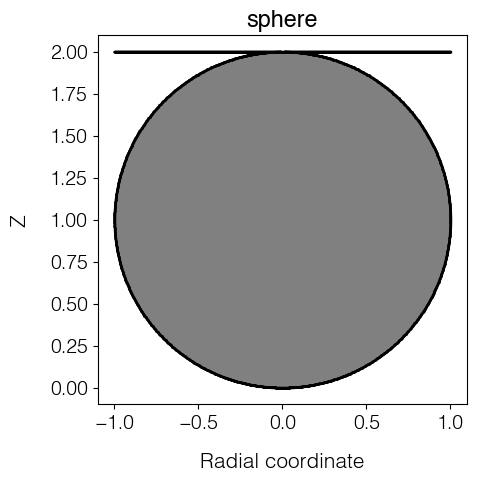

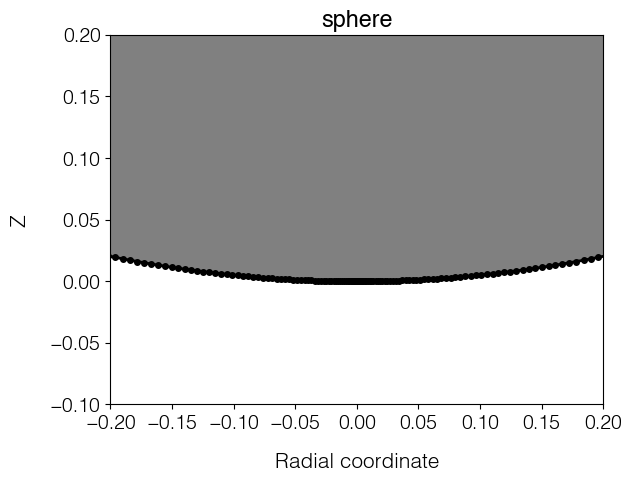

In [352]:
#-- Plot probe shape

P.plot_geometry(ms=1)


P.plot_geometry(ms=4)
plt.xlim(-.2,.2)
plt.ylim(-.1,.2)

<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
<RotationalMoM.ImpedanceMatrix>:
	Preparing dynamic self impedance matrix...
	Progress: 99.74%	Total quadrature time: 11.04s, time per quadrature evaluation: 7.56E-05s


"\nr0=P.get_eigenrhos()[:10]\nr=GapSpectroscopy.get_eigenrhos_AWA().cslice[:10,gap]\nr=AWA(sorted(r,key=lambda r: np.abs(r)))\ndr=(r-r0)\ndr.real.plot(alpha=.3,color='r',lw=10)\ndr.imag.plot(alpha=.3,color='b',lw=10)\nprint(np.abs(dr).max())"

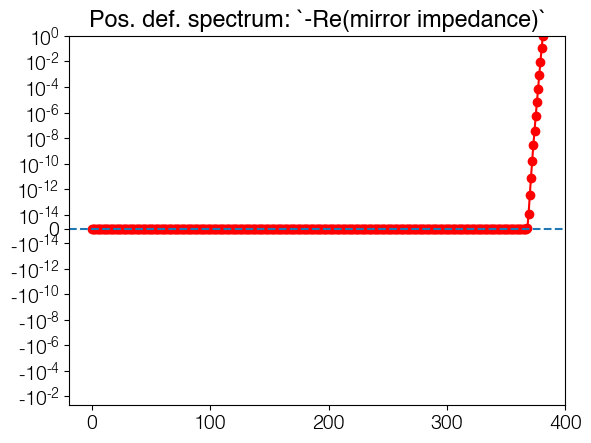

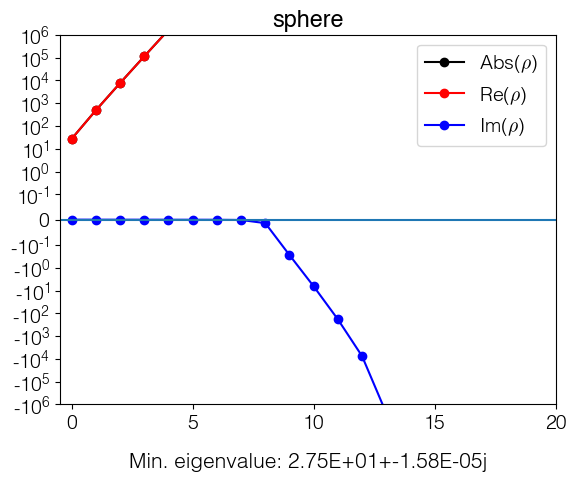

In [353]:
gap=1
P.set_gap(gap)
P.get_mirror_impedance(sommerfeld=True,k=0,recompute=True,
                       Nkappas=244*4,kappa_max=10,kappa_min=None,qquadrature=numrec.GL)
#P.get_mirror_impedance(sommerfeld=False,k=0,recompute=True)
#P.get_self_impedance(recompute=True)
P.solve_eigenmodes(plot=True,condition_ZS=False,condition_ZM=True)
P.plot_eigenrhos()

"""
r0=P.get_eigenrhos()[:10]
r=GapSpectroscopy.get_eigenrhos_AWA().cslice[:10,gap]
r=AWA(sorted(r,key=lambda r: np.abs(r)))
dr=(r-r0)
dr.real.plot(alpha=.3,color='r',lw=10)
dr.imag.plot(alpha=.3,color='b',lw=10)
print(np.abs(dr).max())"""

<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...


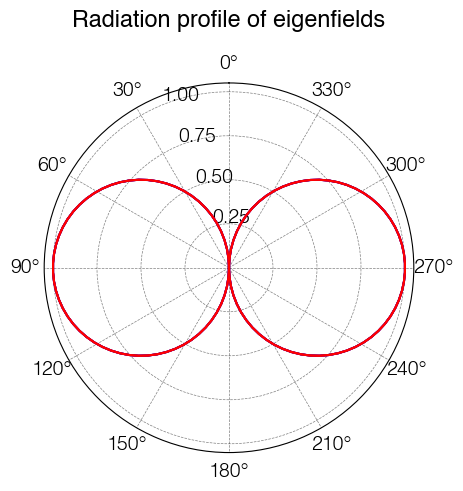

In [354]:
brightnesses=P.get_eigenbrightness(k=None, illum_angles=np.linspace(0, 180, 60),
                                    recompute=True)

N=5
cs = plotting.bluered_colors(N)

fig=plt.figure()
ax=fig.add_subplot(111,projection='polar')
for eigenindex in range(N):
    c=next(cs)
    B = np.abs(brightnesses).cslice[:,eigenindex]
    B /= B.max()
    l,=plt.polar(np.deg2rad(B.axes[0]),B,color=c)
    plt.polar(-np.deg2rad(B.axes[0]),B,color=c)

ax.set_theta_zero_location("N")
plt.xticks(np.deg2rad(np.arange(0,360,30)))
plt.title('Radiation profile of eigenfields',pad=20)
ax.set_rticks([0.25,.5,.75, 1])
g=ax.grid(True,ls='--',alpha=.5,color='k')

Phase (rel. pi/2): 0.01020492071918564
Abs: 0.9999999999991769


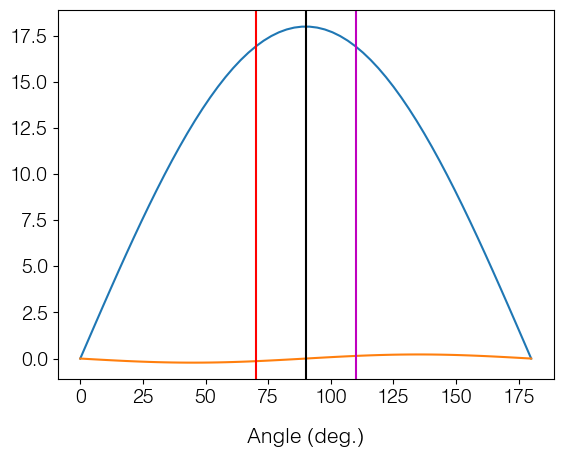

In [355]:
plt.figure()
eigenindex=4
brightnesses.cslice[:,eigenindex].real.plot()
brightnesses.cslice[:,eigenindex].imag.plot()
angle=70; dangle=30
plt.axvline(angle,color='r')
plt.axvline(90,color='k')
plt.axvline(180-angle,color='m')
B1=np.mean(brightnesses.cslice[angle-dangle/2:angle+dangle/2,
                               eigenindex],axis=0)
B2=np.mean(brightnesses.cslice[180-angle-dangle/2:180-angle+dangle/2,
                               eigenindex],axis=0)
print('Phase (rel. pi/2):',np.angle(B2/B1)/(np.pi/2))
print('Abs:',np.abs(B2/B1))

## Examine field at eigenmode

In [356]:
Exc=PCE.EBesselBeamFF()

rho = P.get_eigenrhos()[0]+.01
Q = P.solve_induced_charge_direct(excitation=Exc,\
                                     Vt=None,rho=rho,
                                     Nmodes=20,Veff=True)

rs_out = np.linspace(0,1.5,500)
zs_out = np.linspace(0,3,1000)
Er,Ez = P.computeEfieldImages(Q, rs_out, zs_out, rho=rho,\
                            rp=None, freq=None, Nqs_factor=4,
                            display=True,mirror_double_images=True)

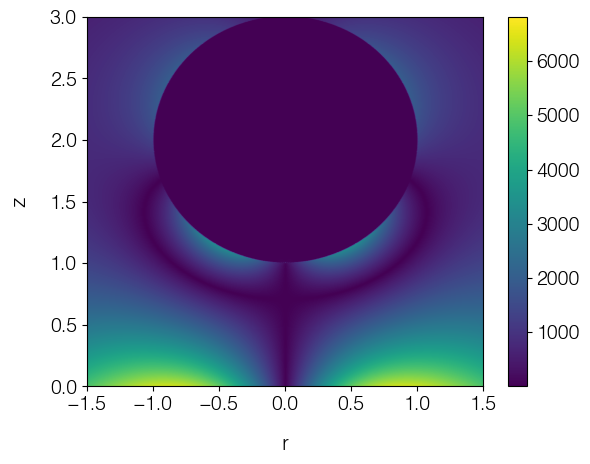

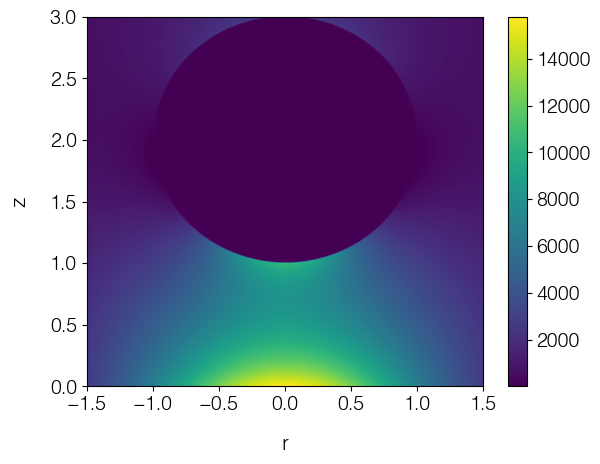

In [357]:
Rs,Zs = Er.axis_grids
Er0,_,Ez0 = Exc(Rs,0,Zs)

np.abs(Er+0*Er0).plot()

plt.figure()
np.abs(Ez+0*Ez0).plot()
#plt.clim(0,1e4)

## Probe spectroscopy

In [644]:
PCE.ProbesCollection.overwrite(True) #This will enable us to reload new probe to overwrite existing

#--- Define function that will run our spectroscopy
# Make it auto-pickling so that subsequent `get..` calls reload rather than recompute the result

gaps = np.logspace(-1.5,1,400)

geometry='sphere'
@misc.autopickle('Probe Models/ProbeGapSpectroscopy_geometry=%s.pickle'%(geometry))
def getGapSpectroscopy1(gaps=gaps, Nmodes=30):
    
    P=P1
    
    P.set_freq(0)
    print('Computing at frequency =',freq0)
    #Don't supply explicit quadrature object, or it will have to be pickled for parallel dispatch
    GS = P.gapSpectroscopy(gaps,recompute=True,Nmodes=30,sommerfeld=True,\
                           Nkappas=244*4,qquadrature='GL')
    #GS = P.gapSpectroscopy(gaps,recompute=True,sommerfeld=False)
    #GS.classify_eigensets(reversed=True,Nmodes=Nmodes) #This happens automatically
    
    return GS

@misc.autopickle('Probe Models/ProbeEncoding_geometry=%s.pickle'%(geometry))
def getProbeEncoding1(GapSpectroscopy,gap0=1,Nmodes=20,Nkappas=244*8,kappa_max=4*np.pi*10,kappa_min=None,):

    GapSpectroscopy.get_probe().set_freq(freq0)
    enc = PS.EncodedEigenfields(GapSpectroscopy,gap0=gap0,Nmodes=Nmodes,\
                                Nkappas=Nkappas,kappa_max=kappa_max,kappa_min=kappa_min)
    
    return enc

<__init__._ProbesCollection.__setitem__>:
	Registering probe "sphere"...
Classifying eigensets by eigenindex...
	Progress: 99.75%<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigenrhos_AWA>:
	For Nmodes=10, there were 339 identifiable mutual coordinates.
[(0, 9), (0.03162277660168379, 4.14757727449845)]


Text(0.5, 0, 'Gap')

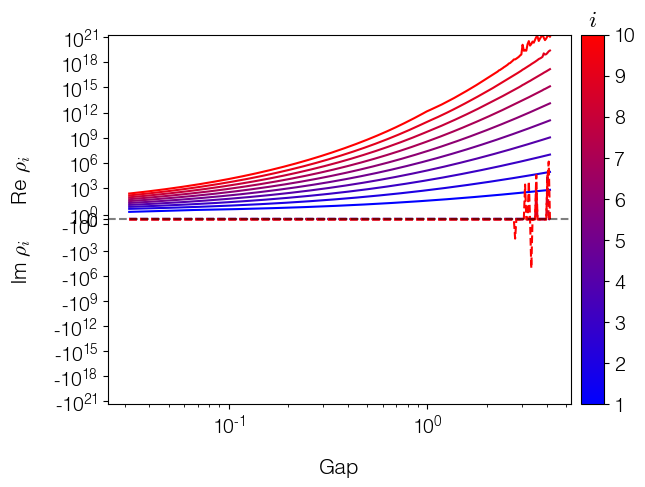

In [645]:
GS1 = getGapSpectroscopy1(recompute=False,overwrite=True,reload=True)
GS1(Nmodes=10,reversed=False,by_rho=True,debug=False)
print(GS1.get_eigenrhos_AWA(Nmodes=10,recompute=True).axis_limits)
GS1.plot_eigenrhos(Nmodes=10)
plt.gcf().axes[0].set_xlabel('Gap')

## Compare with analytic poles

In [38]:
def SpherePoles(gap,k=0,N=100,rho0=1):

    alpha = np.arccosh(1+gap)
    ms = np.arange(N+1)
    
    from scipy.signal import invres
    
    
    Rs = (2*ms+1)**k
    Ps = np.exp((2*ms+1)*alpha)
    
    Bs,As = invres(Rs,Ps,k=0)
    
    return sorted(np.roots(Bs))

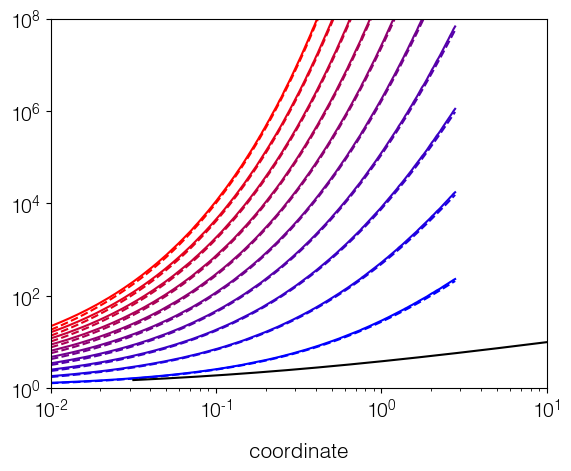

In [40]:
rhos = GS1.get_eigenrhos_AWA()
N=len(rhos)

analytic_rhos=np.array([SpherePoles(gap,N=N) for gap in rhos.axes[1]]).T
analytic_rhos = AWA(analytic_rhos,adopt_axes_from=rhos)
    

N=len(rhos)
cs = plotting.bluered_colors(N)
for k,c in enumerate(cs):
    rhos.cslice[k].plot(color=c)
    analytic_rhos.cslice[k].plot(color=c,ls='--')

plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.ylim(1,1e8)
plt.xlim(1e-2,10)

plt.plot(gaps,1+2*np.sqrt(2*gaps),color='k')

In [41]:
#Encoding = getProbeEncoding(gap0=1,Nmodes=20,Nkappas=244*8,kappa_max=4*np.pi*2,
#                           recompute=True,reload=True,save=False)
#Encoding = getProbeEncoding(GS,gap0=1,Nmodes=15,Nkappas=244*4,kappa_max=2*np.pi*10,kappa_min=None,
#                           recompute=True,reload=True,save=False,overwrite=True)

# Prepare PCE Model - medium QS ellipsoid

## Build Probe

In [42]:
#-- Geometric definitions - explicit lengths in nanometers

a_nm=20
geometry='ellipsoid'
WL_THz_nm=300e3 #300 microns = 1 THz

#-- Geometric definitions - relative to probe radius

L=10
freq_THz=a_nm/WL_THz_nm
freq0=24*freq_THz
gap0=0.1

#-- Build probe

Nsubnodes=2
P2=PCE.Probe(Nnodes=244,Nsubnodes=Nsubnodes,L=L,quadrature=numrec.GL,\
            a=1,geometry=geometry,freq=freq0,gap=gap0,closed=False,name=geometry)

<__init__._ProbesCollection.__setitem__>:
	Registering probe "ellipsoid"...
<__init__.Probe.__init__>:
	Generating probe "ellipsoid"...
<RotationalMoM.get_BoR_radii>:
	Getting geometry for selection "ellipsoid"...
<RotationalMoM.BodyOfRevolution.__init__>:
	Re-meshing provided geometry to quadrature points along annular coordinate `t`...
<RotationalMoM.BodyOfRevolution.__init__>:
	Discretizing body of revolution over 382 annular nodes and 2 subnodes...


(-0.1, 0.2)

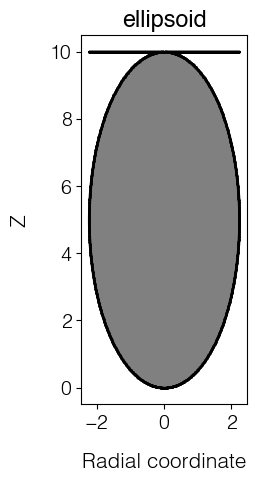

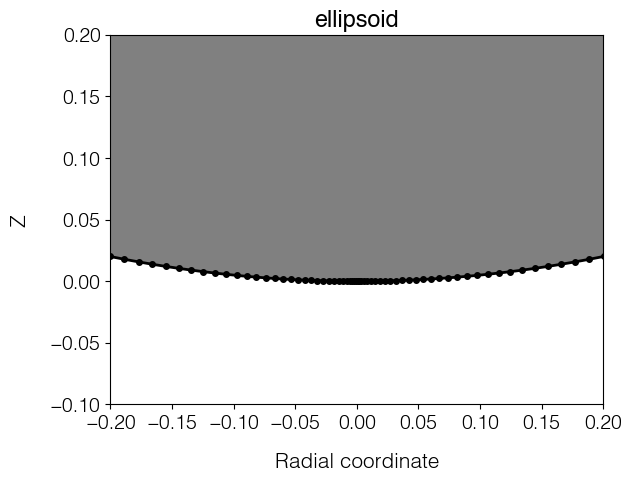

In [43]:
#-- Plot probe shape

P2.plot_geometry(ms=1)


P2.plot_geometry(ms=4)
plt.xlim(-.2,.2)
plt.ylim(-.1,.2)

<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
<RotationalMoM.ImpedanceMatrix>:
	Preparing dynamic self impedance matrix...
	Progress: 99.74%	Total quadrature time: 10.41s, time per quadrature evaluation: 7.14E-05s


"\nr0=P.get_eigenrhos()[:10]\nr=GapSpectroscopy.get_eigenrhos_AWA().cslice[:10,gap]\nr=AWA(sorted(r,key=lambda r: np.abs(r)))\ndr=(r-r0)\ndr.real.plot(alpha=.3,color='r',lw=10)\ndr.imag.plot(alpha=.3,color='b',lw=10)\nprint(np.abs(dr).max())"

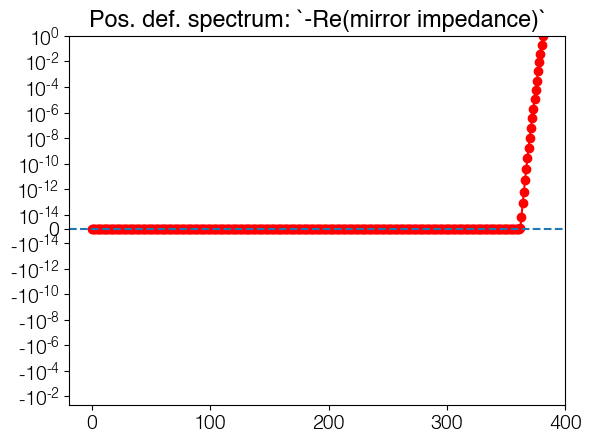

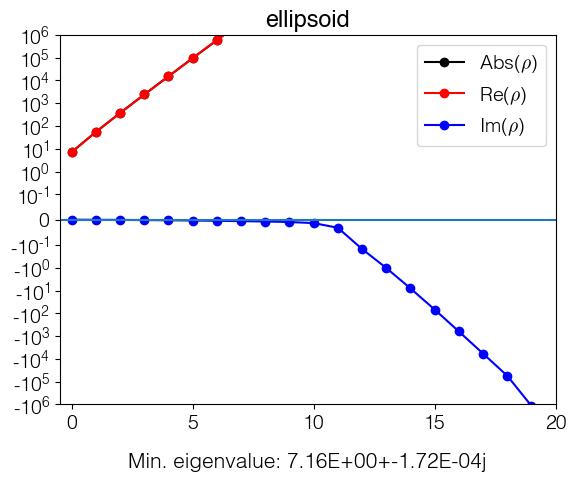

In [44]:
gap=1
P2.set_gap(gap)
P2.get_mirror_impedance(sommerfeld=True,k=0,recompute=True,
                       Nkappas=244*4,kappa_max=10,kappa_min=None,qquadrature=numrec.GL)
#P.get_mirror_impedance(sommerfeld=False,k=0,recompute=True)
#P.get_self_impedance(recompute=True)
P2.solve_eigenmodes(plot=True,condition_ZS=False,condition_ZM=True)
P2.plot_eigenrhos()

"""
r0=P.get_eigenrhos()[:10]
r=GapSpectroscopy.get_eigenrhos_AWA().cslice[:10,gap]
r=AWA(sorted(r,key=lambda r: np.abs(r)))
dr=(r-r0)
dr.real.plot(alpha=.3,color='r',lw=10)
dr.imag.plot(alpha=.3,color='b',lw=10)
print(np.abs(dr).max())"""

<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...


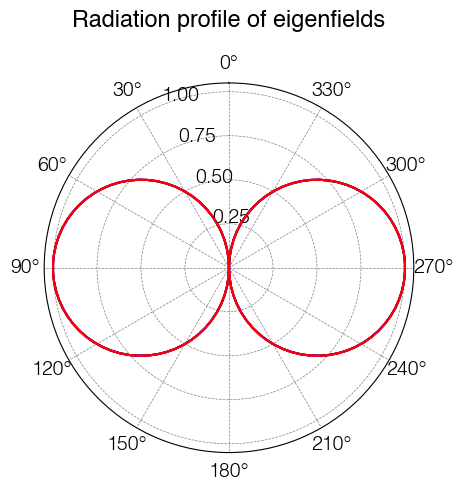

In [45]:
brightnesses=P2.get_eigenbrightness(k=None, illum_angles=np.linspace(0, 180, 60),
                                    recompute=True)

N=5
cs = plotting.bluered_colors(N)

fig=plt.figure()
ax=fig.add_subplot(111,projection='polar')
for eigenindex in range(N):
    c=next(cs)
    B = np.abs(brightnesses).cslice[:,eigenindex]
    B /= B.max()
    l,=plt.polar(np.deg2rad(B.axes[0]),B,color=c)
    plt.polar(-np.deg2rad(B.axes[0]),B,color=c)

ax.set_theta_zero_location("N")
plt.xticks(np.deg2rad(np.arange(0,360,30)))
plt.title('Radiation profile of eigenfields',pad=20)
ax.set_rticks([0.25,.5,.75, 1])
g=ax.grid(True,ls='--',alpha=.5,color='k')

Phase (rel. pi/2): 0.05010930415404919
Abs: 0.9999999937433359


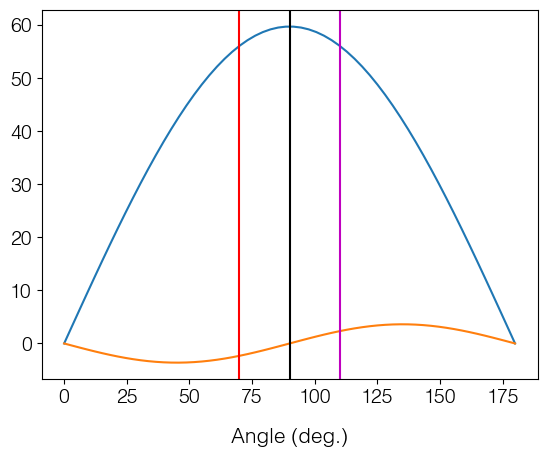

In [46]:
plt.figure()
eigenindex=4
brightnesses.cslice[:,eigenindex].real.plot()
brightnesses.cslice[:,eigenindex].imag.plot()
angle=70; dangle=30
plt.axvline(angle,color='r')
plt.axvline(90,color='k')
plt.axvline(180-angle,color='m')
B1=np.mean(brightnesses.cslice[angle-dangle/2:angle+dangle/2,
                               eigenindex],axis=0)
B2=np.mean(brightnesses.cslice[180-angle-dangle/2:180-angle+dangle/2,
                               eigenindex],axis=0)
print('Phase (rel. pi/2):',np.angle(B2/B1)/(np.pi/2))
print('Abs:',np.abs(B2/B1))

## Examine field at eigenmode

In [47]:
Exc=PCE.EBesselBeamFF()

rho = P2.get_eigenrhos()[0]+.01
Q = P2.solve_induced_charge_direct(excitation=Exc,\
                                     Vt=None,rho=rho,
                                     Nmodes=20,Veff=True)

rs_out = np.linspace(0,4,500)
zs_out = np.linspace(0,10,1000)
Er,Ez = P2.computeEfieldImages(Q, rs_out, zs_out, rho=rho,\
                            rp=None, freq=None, Nqs_factor=4,
                            display=True,mirror_double_images=True)

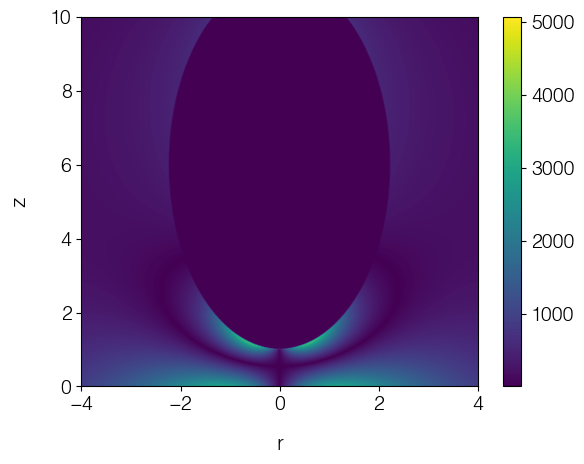

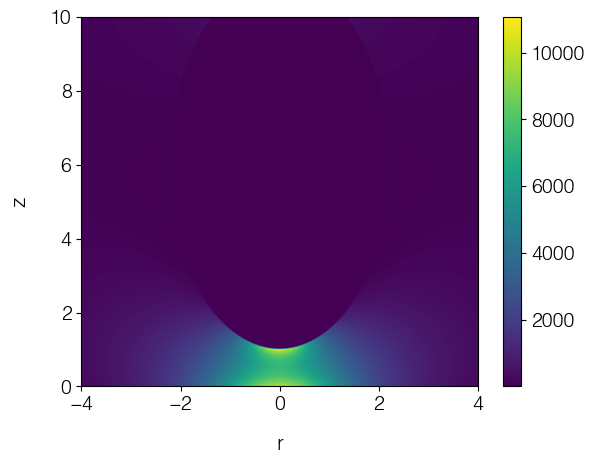

In [48]:
Rs,Zs = Er.axis_grids
Er0,_,Ez0 = Exc(Rs,0,Zs)

np.abs(Er+0*Er0).plot()

plt.figure()
np.abs(Ez+0*Ez0).plot()
#plt.clim(0,1e4)

## Probe spectroscopy

In [646]:
#--- Define function that will run our spectroscopy
# Make it auto-pickling so that subsequent `get..` calls reload rather than recompute the result
PCE.ProbesCollection.overwrite(True) #This will enable us to reload new probe to overwrite existing

gaps = np.logspace(-1.5,1,400)

geometry='ellipsoid'
@misc.autopickle('Probe Models/ProbeGapSpectroscopy_geometry=%s.pickle'%(geometry))
def getGapSpectroscopy2(gaps=gaps, Nmodes=20):
    
    P=P2
    P.set_freq(0)
    print('Computing at frequency =',freq0)
    #Don't supply explicit quadrature object, or it will have to be pickled for parallel dispatch
    GS = P.gapSpectroscopy(gaps,recompute=True,Nmodes=20,sommerfeld=True,\
                           Nkappas=244*4,qquadrature='GL')
    #GS = P.gapSpectroscopy(gaps,recompute=True,sommerfeld=False)
    #GS.classify_eigensets(reversed=True,Nmodes=Nmodes) #This happens automatically
    
    return GS

@misc.autopickle('Probe Models/ProbeEncoding_geometry=%s.pickle'%(geometry))
def getProbeEncoding2(GapSpectroscopy,gap0=1,Nmodes=20,Nkappas=244*8,kappa_max=4*np.pi*10,kappa_min=None,):

    GapSpectroscopy.get_probe().set_freq(freq0)
    enc = PS.EncodedEigenfields(GapSpectroscopy,gap0=gap0,Nmodes=Nmodes,\
                                Nkappas=Nkappas,kappa_max=kappa_max,kappa_min=kappa_min)
    
    return enc

<__init__._ProbesCollection.__setitem__>:
	Overwriting registered probe "ellipsoid"...
Classifying eigensets by eigenindex...
	Progress: 99.75%<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigenrhos_AWA>:
	For Nmodes=10, there were 400 identifiable mutual coordinates.


Text(0.5, 0, 'Gap')

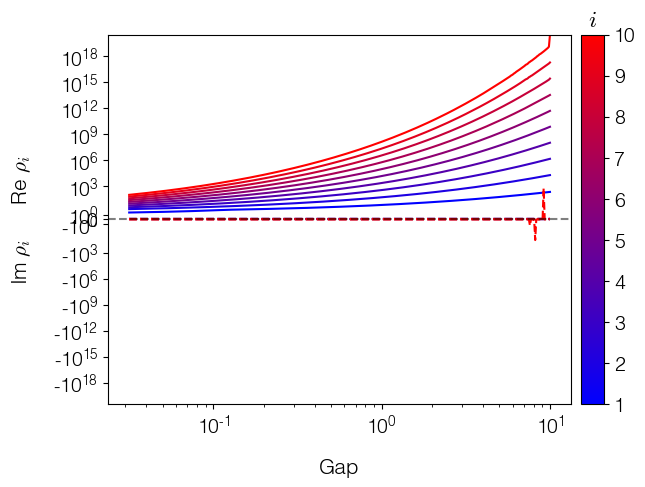

In [650]:
GS2 = getGapSpectroscopy2(recompute=False,overwrite=False,reload=True)
Nmodes=10
GS2(Nmodes=Nmodes,by_rho=True,reversed=False,debug=False)
GS2.plot_eigenrhos(Nmodes=Nmodes,recompute=True)
plt.gcf().axes[0].set_xlabel('Gap')

# Prepare PCE Model - long ED ellipsoid

## Build Probe

In [635]:
#-- Geometric definitions - explicit lengths in nanometers

a_nm=20
geometry='ellipsoid'
WL_THz_nm=300e3 #300 microns = 1 THz

#-- Geometric definitions - relative to probe radius

L=1000
freq_THz=a_nm/WL_THz_nm
freq0=24*freq_THz
gap0=0.1

#-- Build probe

Nsubnodes=2
P3=PCE.Probe(Nnodes=244,Nsubnodes=Nsubnodes,L=L,quadrature=numrec.GL,\
            a=1,geometry=geometry,freq=freq0,gap=gap0,closed=False,name=geometry+'_long')

<__init__._ProbesCollection.__setitem__>:
	Registering probe "ellipsoid_long"...
<__init__.Probe.__init__>:
	Generating probe "ellipsoid_long"...
<RotationalMoM.get_BoR_radii>:
	Getting geometry for selection "ellipsoid"...
<RotationalMoM.BodyOfRevolution.__init__>:
	Re-meshing provided geometry to quadrature points along annular coordinate `t`...
<RotationalMoM.BodyOfRevolution.__init__>:
	Discretizing body of revolution over 382 annular nodes and 2 subnodes...


(-1.0, 5.0)

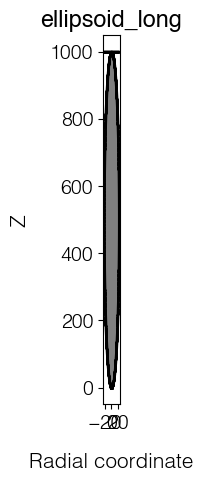

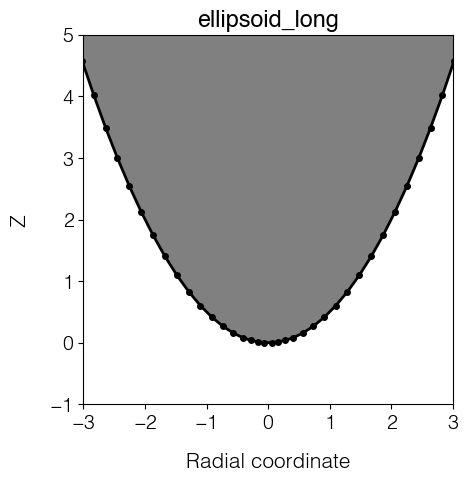

In [636]:
#-- Plot probe shape

P3.plot_geometry(ms=1)


P3.plot_geometry(ms=4)
plt.xlim(-3,3)
plt.ylim(-1,5)

<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
<RotationalMoM.ImpedanceMatrix>:
	Preparing quasistatic mirror impedance matrix...
	Progress: 99.74%	Total quadrature time: 4.97s, time per quadrature evaluation: 3.41E-05s
<RotationalMoM.ImpedanceMatrix>:
	Preparing dynamic self impedance matrix...
	Progress: 99.74%	Total quadrature time: 11.40s, time per quadrature evaluation: 7.81E-05s


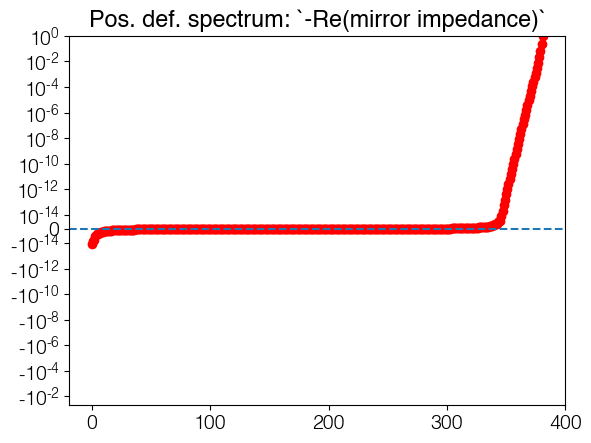

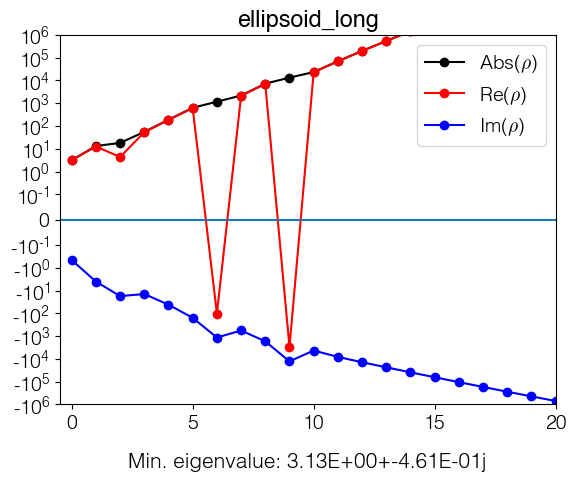

In [637]:
gap=1
P3.set_gap(gap)
P3.get_mirror_impedance(sommerfeld=True,k=0,recompute=True,
                       Nkappas=244*4,kappa_max=10,kappa_min=None,qquadrature=numrec.GL)
P3.get_mirror_impedance(sommerfeld=False,k=0,recompute=True)
P3.solve_eigenmodes(plot=True,condition_ZS=False,condition_ZM=True)
P3.plot_eigenrhos()

## Probe spectroscopy

In [638]:
#--- Define function that will run our spectroscopy
# Make it auto-pickling so that subsequent `get..` calls reload rather than recompute the result
PCE.ProbesCollection.overwrite(True) #This will enable us to reload new probe to overwrite existing

gaps = np.logspace(-1.5,1,400)

geometry='ellipsoid_long'
@misc.autopickle('Probe Models/ProbeGapSpectroscopy_geometry=%s.pickle'%(geometry))
def getGapSpectroscopy3(P, gaps=gaps, Nmodes=20):
    
    P.set_freq(freq0)
    print('Computing at frequency =',freq0)
    #Don't supply explicit quadrature object, or it will have to be pickled for parallel dispatch
    GS = P.gapSpectroscopy(gaps,recompute=True,Nmodes=20,sommerfeld=True,\
                           Nkappas=244*4,qquadrature='GL')
    #GS = P.gapSpectroscopy(gaps,recompute=True,sommerfeld=False)
    #GS.classify_eigensets(reversed=True,Nmodes=Nmodes) #This happens automatically
    
    return GS

@misc.autopickle('Probe Models/ProbeEncoding_geometry=%s.pickle'%(geometry))
def getProbeEncoding3(GapSpectroscopy,gap0=1,Nmodes=20,Nkappas=244*8,kappa_max=np.inf,kappa_min=None,):

    GapSpectroscopy.get_probe().set_freq(freq0)
    enc = PS.EncodedEigenfields(GapSpectroscopy,gap0=gap0,Nmodes=Nmodes,\
                                Nkappas=Nkappas,kappa_max=kappa_max,kappa_min=kappa_min)
    
    return enc

<__init__._ProbesCollection.__setitem__>:
	Overwriting registered probe "ellipsoid_long"...
Classifying eigensets by eigenindex, with reversal...
	Progress: 99.75%<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigenrhos_AWA>:
	For Nmodes=20, there were 400 identifiable mutual coordinates.


Text(0.5, 0, 'Gap')

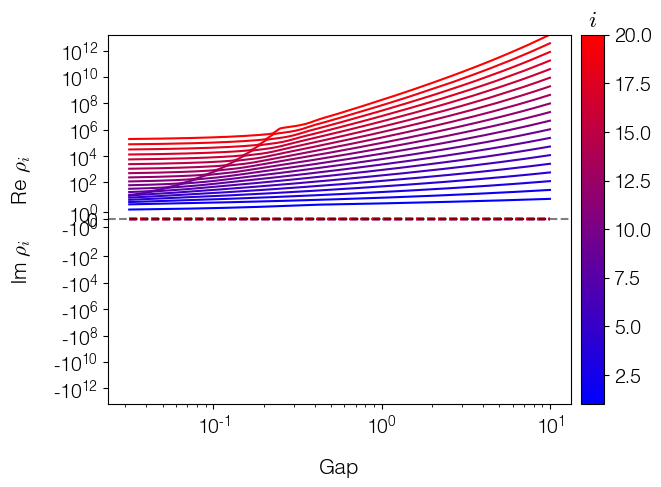

In [639]:
GS3 = getGapSpectroscopy3(P3,recompute=False,overwrite=False,reload=True)
GS3(Nmodes=20,by_rho=True,reversed=True)
GS3.plot_eigenrhos(Nmodes=20,recompute=True)
plt.gcf().axes[0].set_xlabel('Gap')

# Prepare PCE Model - long ED hyperboloid

## Build Probe

In [2]:
#-- Geometric definitions - explicit lengths in nanometers

a_nm=20
geometry='hyperboloid'
taper_angle=17
WL_THz_nm=300e3 #300 microns = 1 THz

#-- Geometric definitions - relative to probe radius

L=1000
freq_THz=a_nm/WL_THz_nm
freq0=24*freq_THz
gap0=0.1

#-- Build probe

Nsubnodes=2
P4=PCE.Probe(Nnodes=244,Nsubnodes=Nsubnodes,L=L,quadrature=numrec.GL,\
            a=1,geometry=geometry,taper_angle=taper_angle,
             freq=freq0,gap=gap0,closed=False,name=geometry)

<__init__._ProbesCollection.__setitem__>:
	Registering probe "hyperboloid"...
<__init__.Probe.__init__>:
	Generating probe "hyperboloid"...
<RotationalMoM.get_BoR_radii>:
	Getting geometry for selection "hyperboloid"...
<RotationalMoM.BodyOfRevolution.__init__>:
	Re-meshing provided geometry to quadrature points along annular coordinate `t`...
<RotationalMoM.BodyOfRevolution.__init__>:
	Discretizing body of revolution over 382 annular nodes and 2 subnodes...


(-1.0, 5.0)

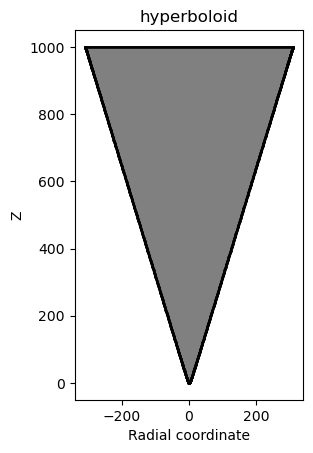

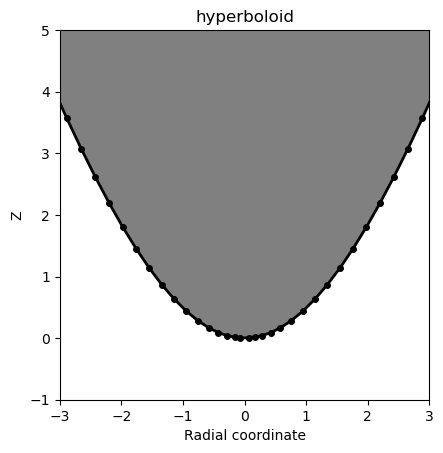

In [3]:
#-- Plot probe shape

P4.plot_geometry(ms=1)


P4.plot_geometry(ms=4)
plt.xlim(-3,3)
plt.ylim(-1,5)

<RotationalMoM.ImpedanceMatrix>:
	Preparing quasistatic mirror impedance matrix at k=0...
	Progress: 99.74%	Total quadrature time: 5.27s, time per quadrature evaluation: 3.61E-05s
<RotationalMoM.ImpedanceMatrix>:
	Preparing dynamic self impedance matrix at k=0.01...
	Progress: 99.74%	Total quadrature time: 13.06s, time per quadrature evaluation: 8.95E-05s


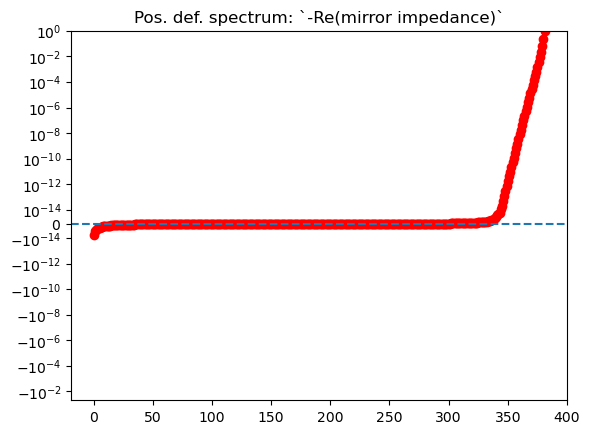

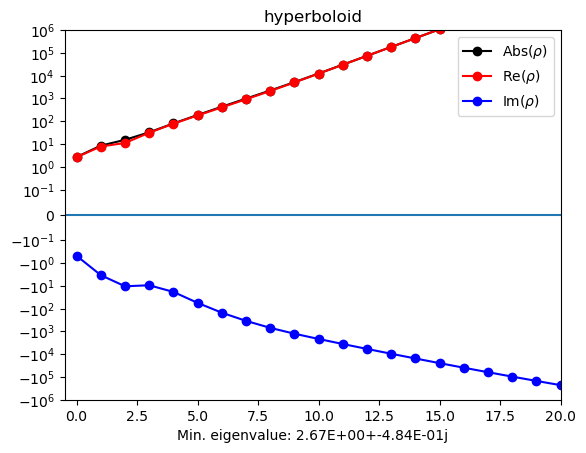

In [4]:
gap=1
P4.set_gap(gap)
#P4.get_mirror_impedance(sommerfeld=True,k=0,recompute=True,
#                       Nkappas=244*4,kappa_max=10,kappa_min=None,qquadrature=numrec.GL)
P4.get_mirror_impedance(sommerfeld=False,k=0,recompute=True)
P4.solve_eigenmodes(plot=True,condition_ZS=False,condition_ZM=True)
P4.plot_eigenrhos()

Qs = P4.get_eigencharges()

## Probe spectroscopy

In [33]:
#--- Define function that will run our spectroscopy
# Make it auto-pickling so that subsequent `get..` calls reload rather than recompute the result
PCE.ProbesCollection.overwrite(True) #This will enable us to reload new probe to overwrite existing

reload(PS)

gaps = np.logspace(-1.75,1.5,400)

geometry='hyperboloid'
@misc.autopickle('Probe models/ProbeGapSpectroscopy_geometry=%s_taper=%i.pickle'%(geometry,taper_angle))
def getGapSpectroscopy4(Nmodes=30, **kwargs):
    
    P=P4
    P.set_freq(freq0)
    print('Computing at frequency =',freq0)
    #Don't supply explicit quadrature object, or it will have to be pickled for parallel dispatch
    GS = P.gapSpectroscopy(gaps,recompute=True,Nmodes=Nmodes,sommerfeld=True,basis_gap=None,\
                           Nkappas=244*4,qquadrature='GL',**kwargs)
    #GS = P.gapSpectroscopy(gaps,recompute=True,sommerfeld=False)
    #GS.classify_eigensets(reversed=True,Nmodes=Nmodes) #This happens automatically
    
    return GS

@misc.autopickle('Probe models/ProbeGapSpectroscopy_geometry=%s_taper=%i_withBasis.pickle'%(geometry,taper_angle))
def getGapSpectroscopy4Basis(basis_gap=0.2,Nmodes=30, **kwargs):
    
    P=P4
    P.set_freq(freq0)
    print('Computing at frequency =',freq0)
    #Don't supply explicit quadrature object, or it will have to be pickled for parallel dispatch
    GS = P.gapSpectroscopy(gaps,recompute=True,Nmodes=Nmodes,sommerfeld=True,basis_gap=basis_gap,\
                           Nkappas=244*4,qquadrature='GL',**kwargs)
    #GS = P.gapSpectroscopy(gaps,recompute=True,sommerfeld=False)
    #GS.classify_eigensets(reversed=True,Nmodes=Nmodes) #This happens automatically
    
    return GS

@misc.autopickle(os.path.join(PS.probe_models_dir,'ProbeEncoding_geometry=%s_taper=%i.pickle'%(geometry,taper_angle)))
def getProbeEncoding4(GapSpectroscopy,gap0=1,Nmodes=20,Nkappas=244*8,kappa_max=4*np.pi*10,kappa_min=None,):

    GapSpectroscopy.get_probe().set_freq(freq0)
    enc = PS.EncodedEigenfields(GapSpectroscopy,gap0=gap0,Nmodes=Nmodes,\
                                Nkappas=Nkappas,kappa_max=kappa_max,kappa_min=kappa_min)
    
    return enc

### Spectroscopy in raw serial form without any projection

<__init__._ProbesCollection.__setitem__>:
	Overwriting registered probe "hyperboloid"...
Classifying eigensets by eigenindex, with reversal...
	Progress: 99.75%<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigenrhos_AWA>:
	For Nmodes=20, there were 284 identifiable mutual coordinates.


Text(0.5, 0, 'Gap')

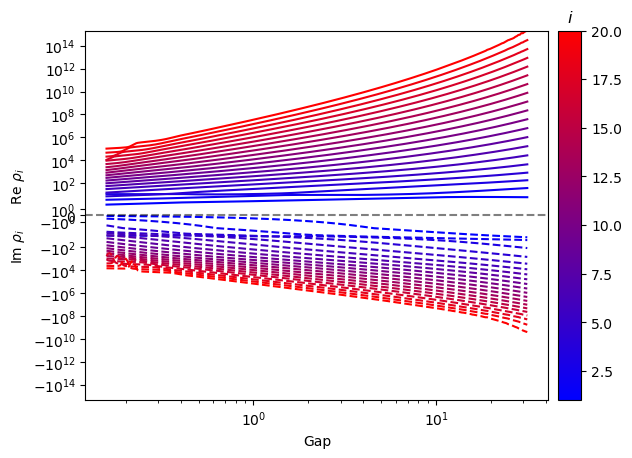

In [6]:
Nmodes=20
GS4_0 = getGapSpectroscopy4(recompute=False,overwrite=True,reload=True,Nmodes=Nmodes)
GS4_0(Nmodes=Nmodes,by_rho=True,reversed=True)
GS4_0.plot_eigenrhos(Nmodes=Nmodes,recompute=True)
plt.gcf().axes[0].set_xlabel('Gap')

### Spectroscopy with projection from gap0

<__init__._ProbesCollection.__setitem__>:
	Overwriting registered probe "hyperboloid"...
Classifying eigensets by eigenindex, with reversal...
	Progress: 99.75%<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigenrhos_AWA>:
	For Nmodes=15, there were 359 identifiable mutual coordinates.


Text(0.5, 0, 'Gap')

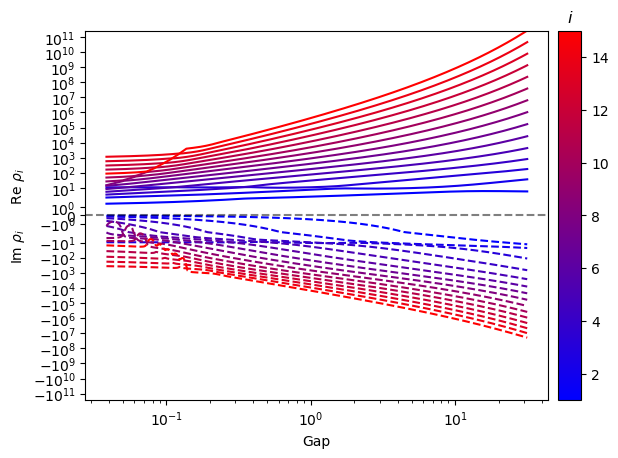

In [7]:
Nmodes = 15
GS4 = getGapSpectroscopy4Basis(recompute=False,overwrite=False,reload=True,basis_gap=1,Nmodes=60)
GS4(Nmodes=Nmodes,by_rho=True,reversed=True)
GS4.plot_eigenrhos(Nmodes=Nmodes,recompute=True)
plt.gcf().axes[0].set_xlabel('Gap')

### Compare result with and without basis in calculation

(0.0, 10.0)

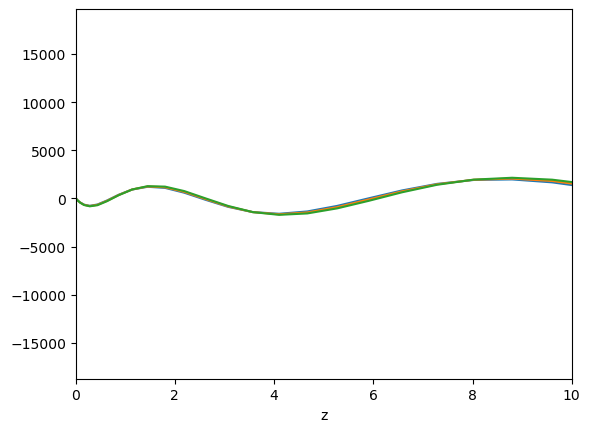

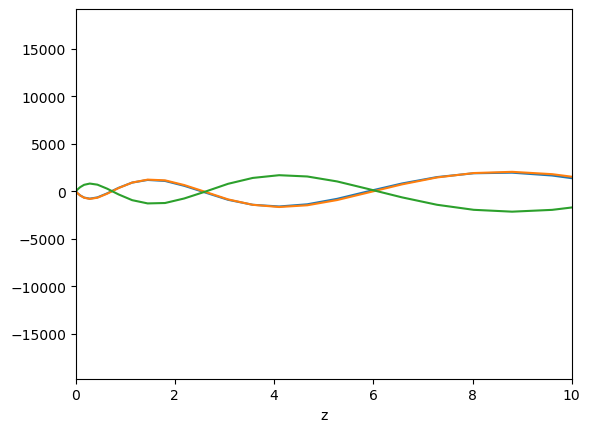

In [8]:
coords=np.array(list(GS4_0._recorded_eigencharges.keys()))

coord = 5
N=13
ind = np.argmin((coords-coord)**2)
Q1 = GS4_0._recorded_eigencharges[coords[ind]][N]
Q2 = GS4_0._recorded_eigencharges[coords[ind+1]][N]
Q3 = GS4_0._recorded_eigencharges[coords[ind+2]][N]

Q1.real.plot()
(-Q2).real.plot()
(Q3).real.plot()
plt.xlim(0,10)


plt.figure()

Q1 = GS4._recorded_eigencharges[coords[ind]][N]
Q2 = GS4._recorded_eigencharges[coords[ind+1]][N]
Q3 = GS4._recorded_eigencharges[coords[ind+2]][N]

Q1.real.plot()
(Q2).real.plot()
(Q3).real.plot()
plt.xlim(0,10)

<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigenrhos_AWA>:
	For Nmodes=15, there were 359 identifiable mutual coordinates.
<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigencharges_AWA>:
	Obtaining eigencharges for Nmodes=20, across  284 mutual spectroscopy coordinates.
	Aligning eigencharge signage...
	Progress: 99.30%<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigencharges_AWA>:
	Obtaining eigencharges for Nmodes=15, across  359 mutual spectroscopy coordinates.
	Aligning eigencharge signage...
	Progress: 99.44%

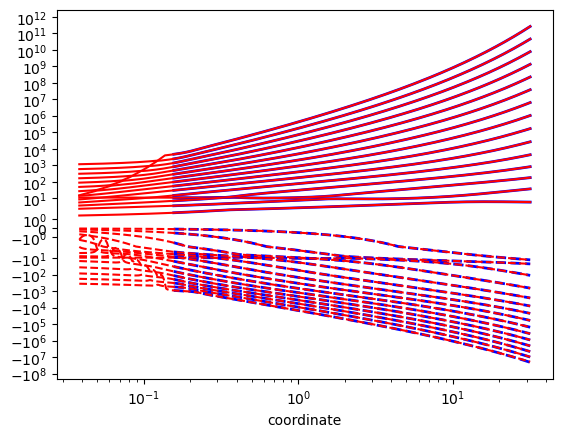

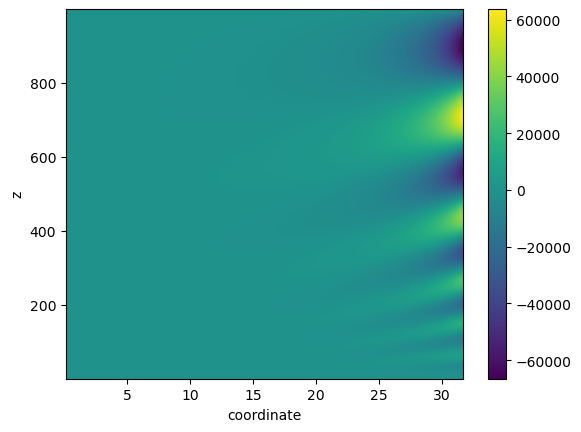

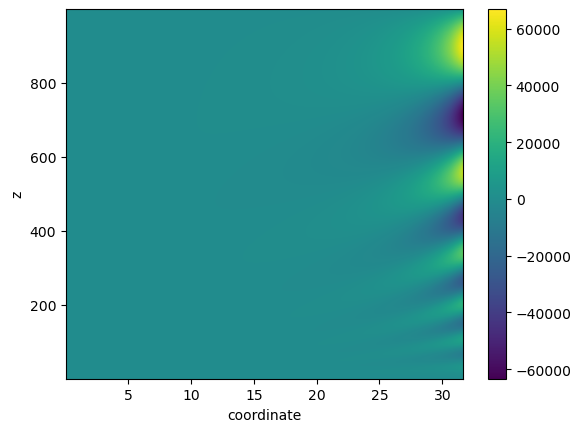

In [9]:
rhos0=GS4_0.get_eigenrhos_AWA(Nmodes=20)
rhos4=GS4.get_eigenrhos_AWA(Nmodes=20)

Qs0=GS4_0.get_eigencharges_AWA(Nmodes=20)
Qs4=GS4.get_eigencharges_AWA(Nmodes=20)

for N in range(15):
    try: rhos0[N].real.plot(color='b',lw=2)
    except IndexError: pass
    rhos4[N].real.plot(color='r')
    
    try: rhos0[N].imag.plot(color='b',lw=2,ls='--')
    except IndexError: pass
    rhos4[N].imag.plot(color='r',ls='--')
plt.gca().set_yscale('symlog')
plt.gca().set_xscale('log')

N=10
plt.figure()
Qs0[N].real.plot()
plt.figure()
Qs4[N].real.plot()

## Finite multipole fit to eigenpotential spectrum

In [65]:
GS = PCE.ProbesCollection['hyperboloid'].gapSpectroscopy()

In [67]:
reload(PS)
PE=getProbeEncoding4(GS,reload=True,overwrite=True,recompute=True)

<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigencharges_AWA>:
	Obtaining eigencharges for Nmodes=15, across  400 mutual spectroscopy coordinates.
	Aligning eigencharge signage...
	Progress: 99.50%<ProbeSpectroscopy.EncodedEigenfields.__init__>:
	Encoding eigenfields to gap=1 across 400 gap values from gap=0.032 to 10...
<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 9.94E-01...
	Updating eigencharges...
	Updating self impedance...
	Updating mirror impedance...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigenbrightness_AWA>:
	Computing brightnesses across 400 spectroscopy coordinates...
<__init__._ProbesCollection.__setitem__>:
	Overwriting registered probe "hyperboloid"...


error= 0.14008525895380386
error= 0.11536175984470544
error= 0.10091220949098365
error= 0.11000980274109246
error= 0.08270346298838192
error= 0.07454976958401446
error= 0.072369661069421
error= 0.07530948911671563
error= 0.07659738993061088
error= 0.07108382260622402
error= 0.06849527514059779
error= 0.0712742057967623
error= 0.06124204497260308
error= 0.0563752544180071
error= 0.055694242143787515
error= 0.06249714895261837
error= 0.04558662550442469
error= 0.04170250475439926
error= 0.041136290678514376
error= 0.04196362633882162
error= 0.03785390913615694
error= 0.033719458502878816
error= 0.032617051887022415
error= 0.03517907539998472
error= 0.03684868922903019
error= 0.03484672679010982
error= 0.03299810835666775
error= 0.03467218878061513
error= 0.03261450250284862
error= 0.028708916424847627
--- Best fit has error = 0.0326 ---
--- Dipole 1 parameters: ---
kappa0= 0.0012363619947422517
Qr= 1.747946530465712
Qi= -0.22039221348911742
--- Dipole 2 parameters: ---
kappa0= 0.01292608

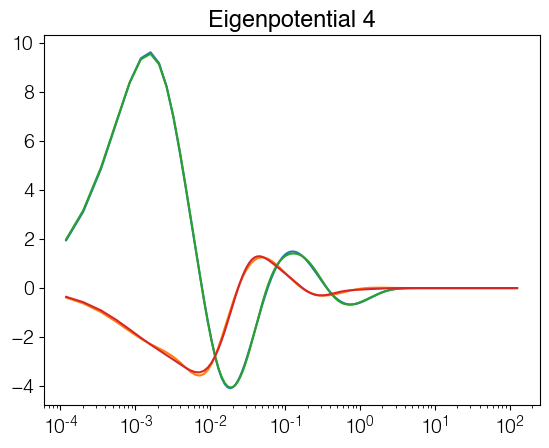

In [1332]:
fit = PE.Phi_fit(4, randomization=.05, Ndipoles=None, target_error=.03,
                rounds=4, error_exp_max=4, plot=True,kappa0=1e-2
                )

In [1298]:
GS = PCE.ProbesCollection['hyperboloid'].gapSpectroscopy()
PE=getProbeEncoding4(GS)
kappas=PE.kappas

from numba import njit

@njit
def PhiFit(kappas,fit):
    
    #assert len(fit)%3 == 0
    order = len(fit)//3
    
    total = (0+0j)*kappas
    for n in range(order):
        kappa0,qr,qi = fit[3*n:3*(n+1)]
        q = (qr + 1j*qi) / kappa0
        total = 10 * q*np.exp(-kappas/kappa0) + total
    
    #This is now a sum of dipoles, carrying the factor of q for radial integral or dz operator
    return total * kappas

def print_fit(fit):
    
    for n in range(len(fit)//3):
        print('kappa0=',fit[3*n])
        print('Qr=',fit[3*n+1])
        print('Qi=',fit[3*n+2])

def randomize(fit,f=.1):
    
    N=len(fit)
    r = np.random.randn(N)
    fit = np.array(fit)*(1+f*r)
    
    return fit

def do_fit(N,rounds=4,randomization=.1,target=.01):
    
    global kappas,PE

    P = PE.Phis0[N-1]

    plt.figure()
    plt.title(N)
    plt.semilogx(kappas,P.real,kappas,P.imag)

    kappa0 = 1e-3
    fit = [kappa0,-1.,1.]
    order = N+2
    for n in range(order):
        kappanew = kappa0 * 2**(n+1)
        fit += [kappanew,
                1**(n+1)*1.,
                -1**(n+1)*1.]

    tol=1e-12
    error=1
    Pfit = PhiFit(kappas,fit)
    error_exps = np.linspace(4,.5,rounds)
    try:
        while error>target or not np.isfinite(error):
            for i in range(rounds):
                error_exp = error_exps[i]

                #error_exp = error_exps[i]
                fitnew = numrec.ParameterFit(kappas,P,PhiFit,fit,error_exp=error_exp,ftol=tol,xtol=tol)[0]
                
                Pfit = PhiFit(kappas,fitnew)
                if np.isfinite(Pfit).all(): fit = fitnew
                else: print('blowup identified!')

                error = np.sqrt(np.sum(np.abs(P-Pfit)**2))
                error /= np.sqrt(np.sum(np.abs(P)**2))
                print('error=',error)
                if error < target: break
                    
            fit = randomize(fit,randomization)
                    
    except KeyboardInterrupt: pass

    plt.plot(kappas, Pfit.real, kappas, Pfit.imag)
    
    return fit

N= 8
error= 0.27487707816026774
error= 0.12038801397281629
error= 0.07029813257791377
error= 0.07299703255585745
error= 0.03945153235830634


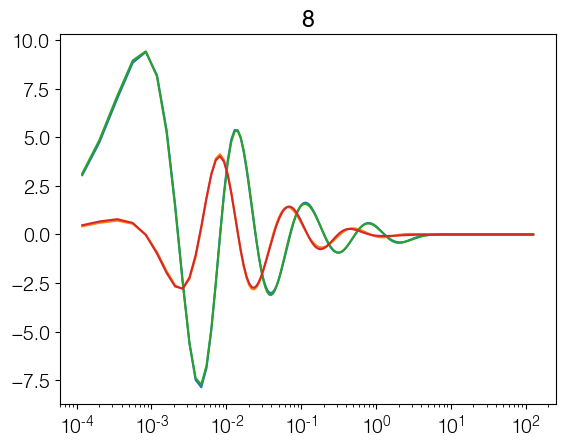

In [1299]:
fits=[]
for N in [8]:#np.arange(8)+1:
    print('N=',N)
    fit=do_fit(N,rounds=4,randomization=.05,target=.07)
    fits.append(fit)

# Prepare PCE Model - long blunt QS ellipsoid

## Build Probe

In [381]:
#-- Geometric definitions - explicit lengths in nanometers

a_nm=20
geometry='ellipsoid'
WL_THz_nm=300e3 #300 microns = 1 THz

#-- Geometric definitions - relative to probe radius

L=1000
freq_THz=a_nm/WL_THz_nm
freq0=24*freq_THz
gap0=0.1

#-- Build probe

Nsubnodes=2
P5=PCE.Probe(Nnodes=244,Nsubnodes=Nsubnodes,L=L,quadrature=numrec.GL,\
            a=20,geometry=geometry,freq=freq0,gap=gap0,closed=False,name=geometry+'_long_blunt')

<__init__._ProbesCollection.__setitem__>:
	Overwriting registered probe "ellipsoid_long_blunt"...
<__init__.Probe.__init__>:
	Generating probe "ellipsoid_long_blunt"...
<RotationalMoM.get_BoR_radii>:
	Getting geometry for selection "ellipsoid"...
<RotationalMoM.BodyOfRevolution.__init__>:
	Re-meshing provided geometry to quadrature points along annular coordinate `t`...
<RotationalMoM.BodyOfRevolution.__init__>:
	Discretizing body of revolution over 382 annular nodes and 2 subnodes...


(-1.0, 5.0)

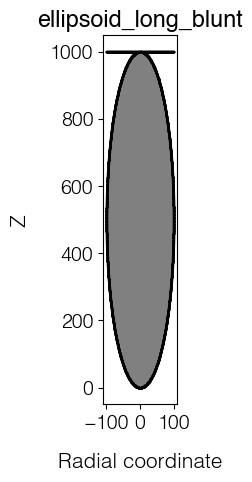

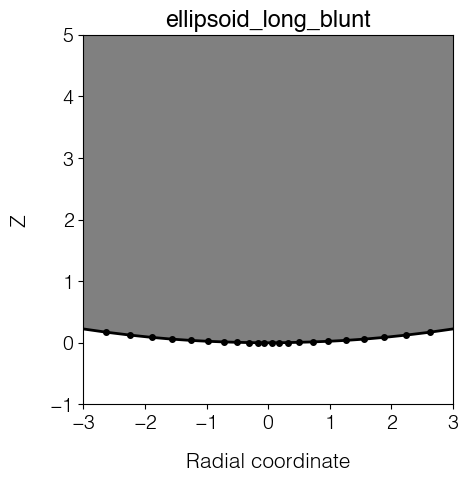

In [382]:
#-- Plot probe shape

P5.plot_geometry(ms=1)


P5.plot_geometry(ms=4)
plt.xlim(-3,3)
plt.ylim(-1,5)

<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
<RotationalMoM.ImpedanceMatrix>:
	Preparing quasistatic mirror impedance matrix...
	Progress: 99.74%	Total quadrature time: 5.09s, time per quadrature evaluation: 3.49E-05s
<RotationalMoM.ImpedanceMatrix>:
	Preparing dynamic self impedance matrix...
	Progress: 99.74%	Total quadrature time: 11.69s, time per quadrature evaluation: 8.01E-05s


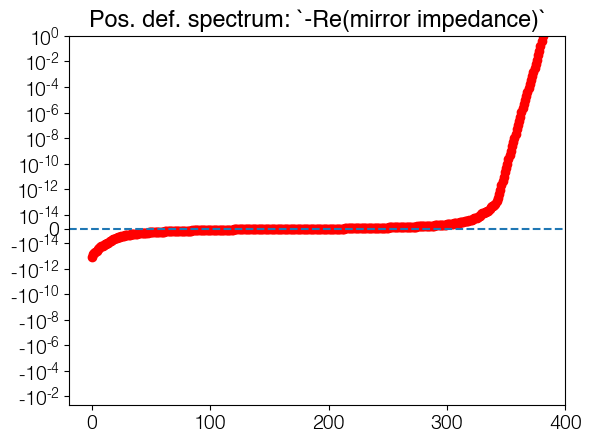

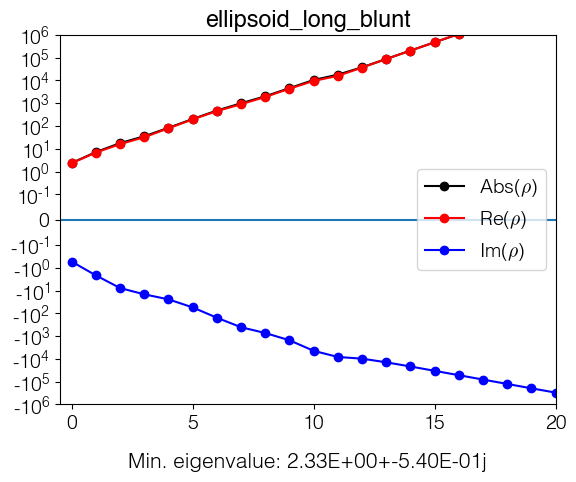

In [383]:
gap=4
P5.set_gap(gap)
P5.get_mirror_impedance(sommerfeld=True,k=0,recompute=True,
                       Nkappas=244*4,kappa_max=10,kappa_min=None,qquadrature=numrec.GL)
P5.get_mirror_impedance(sommerfeld=False,k=0,recompute=True)
P5.solve_eigenmodes(plot=True,condition_ZS=False,condition_ZM=True)
P5.plot_eigenrhos()

## Probe spectroscopy

In [654]:
#--- Define function that will run our spectroscopy
# Make it auto-pickling so that subsequent `get..` calls reload rather than recompute the result

gaps = np.logspace(-1.5,1,400)

geometry='ellipsoid_long_blunt'
@misc.autopickle('Probe Models/ProbeGapSpectroscopy_geometry=%s.pickle'%(geometry))
def getGapSpectroscopy5(gaps=gaps, Nmodes=20):
    
    P=P5
    P.set_freq(0)
    print('Computing at frequency =',freq0)
    #Don't supply explicit quadrature object, or it will have to be pickled for parallel dispatch
    GS = P.gapSpectroscopy(gaps,recompute=True,Nmodes=20,sommerfeld=True,\
                           Nkappas=244*4,qquadrature='GL')
    #GS = P.gapSpectroscopy(gaps,recompute=True,sommerfeld=False)
    #GS.classify_eigensets(reversed=True,Nmodes=Nmodes) #This happens automatically
    
    return GS

@misc.autopickle('Probe Models/ProbeEncoding_geometry=%s.pickle'%(geometry))
def getProbeEncoding5(GapSpectroscopy,gap0=1,Nmodes=20,Nkappas=244*8,kappa_max=4*np.pi*10,kappa_min=None,):

    GapSpectroscopy.get_probe().set_freq(freq0)
    enc = PS.EncodedEigenfields(GapSpectroscopy,gap0=gap0,Nmodes=Nmodes,\
                                Nkappas=Nkappas,kappa_max=kappa_max,kappa_min=kappa_min)
    
    return enc

<__init__._ProbesCollection.__setitem__>:
	Registering probe "ellipsoid_long_blunt"...
Classifying eigensets by eigenindex, with reversal...
	Progress: 99.75%<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigenrhos_AWA>:
	For Nmodes=25, there were 243 identifiable mutual coordinates.


Text(0.5, 0, 'Gap')

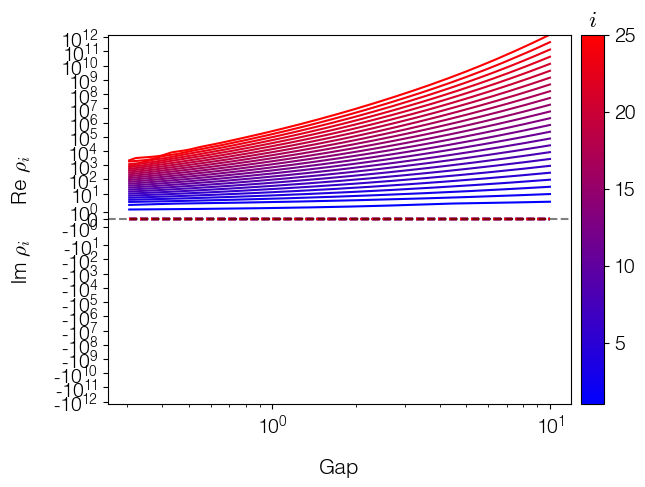

In [655]:
GS5 = getGapSpectroscopy5(recompute=False,overwrite=False,reload=True)
Nmodes=25
GS5(Nmodes=Nmodes,by_rho=True,reversed=True,debug=False)
GS5.plot_eigenrhos(Nmodes=Nmodes,recompute=True)
plt.gcf().axes[0].set_xlabel('Gap')

# Compare probes

* Blunt probes are hard to calculate, as they require many modes to capture the physics (30 for the blunt ellipsoid!)
* Approach curves indeed show that a probe is 10x more blunt... but only when reflection coefficient is small (.1)
* At larger reflection coefficient, there is "merging" onto a common curve that is logarithmic in distance.
* Larger reflection engages higher order modes, which are more delocalized (lower momentum)..
    * But why logarithmic?

<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 9.94E-01...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..


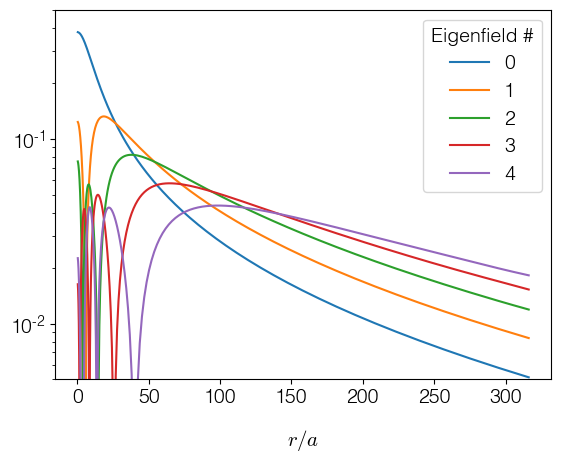

In [502]:
P5 = GS5.get_probe_at_coord(1)
Phi,Az,Ar,Ez=P5.getFourPotentialAtZ(k=0,rs=np.logspace(-.5,2.5,200))
for ei in range(5):
    np.abs(Phi[ei]).plot(label=ei)

#plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.ylim(5e-3,.5)
plt.legend(title='Eigenfield #')

## Compute eigencharges for all probes

In [657]:
Nmodes=15
#Be careful, if we update number of modes, eigenrhos must be updated FIRST because the others refer to them internally

Ps1=GS1.get_eigenrhos_AWA(Nmodes=10,recompute=False) # We cannot easily get more than 10
Ps2=GS2.get_eigenrhos_AWA(Nmodes=Nmodes,recompute=True)
Ps3=GS3.get_eigenrhos_AWA(Nmodes=Nmodes,recompute=True)
Ps4=GS4.get_eigenrhos_AWA(Nmodes=Nmodes,recompute=True)
Ps5=GS5.get_eigenrhos_AWA(Nmodes=25,recompute=True) # We cannot survive with fewer than 25

GS1.get_eigencharges_AWA(Nmodes=10)
GS2.get_eigencharges_AWA(Nmodes=Nmodes)
GS3.get_eigencharges_AWA(Nmodes=Nmodes,recompute=True)
GS4.get_eigencharges_AWA(Nmodes=Nmodes,recompute=True)
GS5.get_eigencharges_AWA(Nmodes=25,recompute=True)

Bs1=GS1.get_eigenbrightness_AWA(Nmodes=10)
Bs2=GS2.get_eigenbrightness_AWA(Nmodes=Nmodes)
Bs3=GS3.get_eigenbrightness_AWA(Nmodes=Nmodes,recompute=True)
Bs4=GS4.get_eigenbrightness_AWA(Nmodes=Nmodes,recompute=True)
Bs5=GS5.get_eigenbrightness_AWA(Nmodes=25,recompute=True)

<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigenrhos_AWA>:
	For Nmodes=10, there were 400 identifiable mutual coordinates.
<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigenrhos_AWA>:
	For Nmodes=15, there were 400 identifiable mutual coordinates.
<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigenrhos_AWA>:
	For Nmodes=15, there were 340 identifiable mutual coordinates.
<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigenrhos_AWA>:
	For Nmodes=25, there were 243 identifiable mutual coordinates.
<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigencharges_AWA>:
	Obtaining eigencharges for Nmodes=10, across  400 mutual spectroscopy coordinates.
	Aligning eigencharge signage...
	Progress: 99.50%<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigencharges_AWA>:
	Obtaining eigencharges for Nmodes=15, across  400 mutual spectroscopy coordinates.
	Aligning eigencharge signage...
	Progress: 99.50%<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigencharg

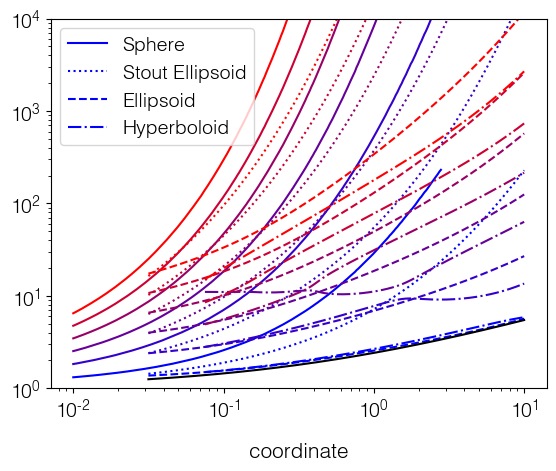

In [70]:
rhos1=GS1.get_eigenrhos_AWA()
rhos2=GS2.get_eigenrhos_AWA()
rhos3=GS3.get_eigenrhos_AWA()
rhos4=GS4.get_eigenrhos_AWA()
rhos5=GS5.get_eigenrhos_AWA()
scale=1

N=6
cs=plotting.bluered_colors(N)

for i,c in enumerate(cs):
    if i==0:
        label1='Sphere'
        label2='Stout Ellipsoid'
        label3='Ellipsoid'
        label4='Hyperboloid'
    else: label1=label2=label3=label4=''
    rhos1.cslice[i].plot(color=c,label=label1)
    rhos2.cslice[i].plot(color=c,ls=':',label=label2)
    rhos3.cslice[i].plot(color=c,ls='--',label=label3)
    rhos4.cslice[i].plot(color=c,ls='dashdot',label=label4)
    
    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')
    l=plt.gca().lines[-1]
    l.set_xdata(l.get_xdata()*scale)
    
plt.ylim(1,1e4)
plt.legend()
#The universal curve (small-z) for a quadratic surface above half-space
#Strictly speaking this is for the parallel polarization eigenrho
plt.plot(gaps,1+np.sqrt(2*gaps),color='k')

## Approach Curves

### Direct calculation with the probes

In [455]:
beta = .3 #(11.7-1)/(11.7+1)
#beta_si = lambda freq,q: M.Si.reflection_p(freq/20e-7,q/20e-7)
gaps = np.logspace(-1,1.5,20)
Nmodes=20

amplitude=1
kwargs=dict(freq=freq0,gaps=gaps,amplitude=amplitude,\
                                    Nzs_demod=20,zquadrature=numrec.GL,\
                                    Nmodes=Nmodes,illum_angles=None,\
                                    rp=beta,recompute_rp=True,demod_order=4,\
                                    recompute_propagators=True,
                                    recompute_brightness=True,Nkappas=244)

probes=['sphere',
        'ellipsoid',
        'ellipsoid_long',
         'ellipsoid_long_blunt',
         'hyperboloid']

acs={}
erads={}
for probe in probes:
    AC=PCE.PC[probe].EradApproachCurveDemodulated(**kwargs)
    ac=AC['Sn'][3]
    ac/=np.abs(ac).max()
    acs[probe]=ac
    erads[probe]=AC['Erad']

<__init__.Probe.EradApproachCurveDemodulated>:
	Building approach curve...
	Working on z=0.10...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0016...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
	Working on z=0.14...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0016...
	Working on z=0.18...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0016...
	Working on z=0.25...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0016...
	Working on z=0.34...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0016...
	Working on z=0.45...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0016...
	Working on z=0.62...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0016...
	Working on z=0.83...
<__init__.Probe.EradVsGap>:
	Comput

	Working on z=5.13...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0016...
	Working on z=6.95...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0016...
	Working on z=9.41...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0016...
	Working on z=12.74...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0016...
	Working on z=17.25...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0016...
	Working on z=23.36...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0016...
	Working on z=31.62...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0016...
		Time elapsed: 5.760892152786255
<__init__.Probe.EradApproachCurveDemodulated>:
	Building approach curve...
	Working on z=0.10...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0016...
<__init__.Probe.getFourPotentialPropagators

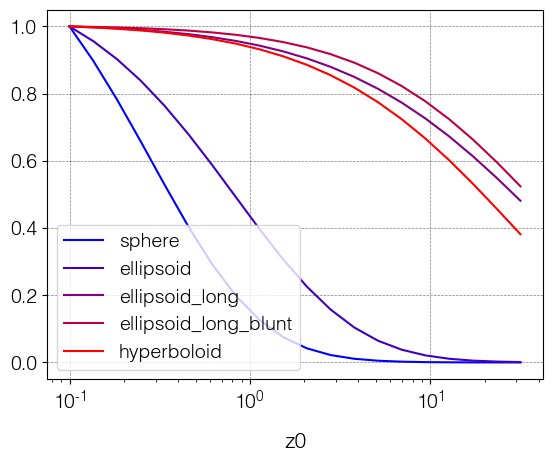

In [456]:
cs=plotting.bluered_colors(len(probes))
for probe in probes:
    c=next(cs)
    erad=erads[probe]
    erad/=np.abs(erad).max()
    np.abs(erad).plot(color=c,label=probe)
plt.gca().set_xscale('log')
#plt.gca().set_yscale('log')
plt.legend()
plt.grid(color='k')

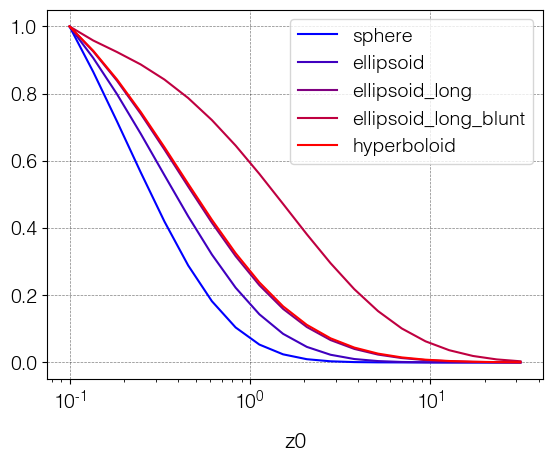

In [461]:
cs=plotting.bluered_colors(len(probes))
for probe in probes:
    c=next(cs)
    ac=acs[probe]
    np.abs(ac).plot(color=c,label=probe)
plt.gca().set_xscale('log')
plt.legend()
plt.grid(color='k')
#plt.xlim(0,3)

### Direct calculation versus gap spectroscopy method

working on probe = sphere
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
working on probe = ellipsoid
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
working on probe = ellipsoid_long
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
working on probe = ellipsoid_long_blunt
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
<__init__.Probe.EradVsGap>

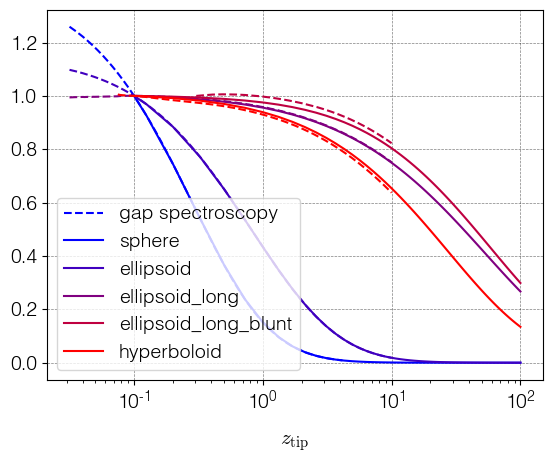

In [476]:
from NearFieldOptics import Materials as M
Nmodes=25

plt.figure()

cs=plotting.bluered_colors(len(probes))

label='gap spectroscopy'
for probe in probes:
    print('working on probe = %s'%probe)
    P=PCE.PC[probe]
    GS = P.gapSpectroscopy()
    c=next(cs)
    Bs=GS.get_eigenbrightness_AWA()[:Nmodes]
    Ps=GS.get_eigenrhos_AWA()[:Nmodes]
    
    Erad0 = np.abs(np.sum((Bs**2/(beta-Ps)+Bs**2/Ps)[:Nmodes],axis=0))
    Erad0/=np.abs(Erad0).cslice[.1]
    np.abs(Erad0).plot(color=c,ls='--',label=label)
    label=''

    if probe=='hyperboloid': freq=freq0
    else: freq=0
    Erad=np.abs(P.EradVsGap(freq=freq,gapmin=.1,gapmax=100,Ngaps=100,
                     Nmodes=Nmodes,illum_angles=None,rp=beta)['Erad'])
    Erad/=np.abs(Erad).cslice[.1]
    np.abs(Erad).plot(color=c,ls='-',label=probe)

plt.grid(color='k')

plt.gca().set_xscale('log')
plt.legend()
#plt.gca().set_yscale('log')


#gaps_dense=np.logspace(-1.5,2,100)
#plt.semilogx(gaps_dense,2.14-.4*np.log(gaps_dense),color='k')

[(0, 5), (0.03162277660168379, 2.0475772744984497)] ['$n$', 'axis1']
[(0, 5), (0.03162277660168379, 7.9)] ['$n$', 'axis1']
[(0, 5), (0.03162277660168379, 7.9)] ['$n$', 'axis1']
[(0, 5), (0.3045855340674284, 7.9)] ['$n$', 'axis1']
[(0, 5), (0.07515188004346636, 7.9)] ['$n$', 'axis1']


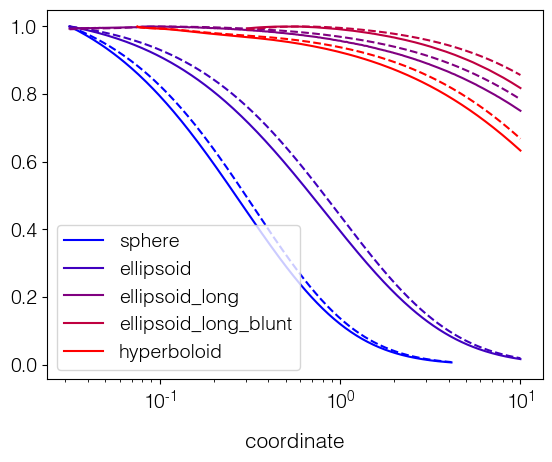

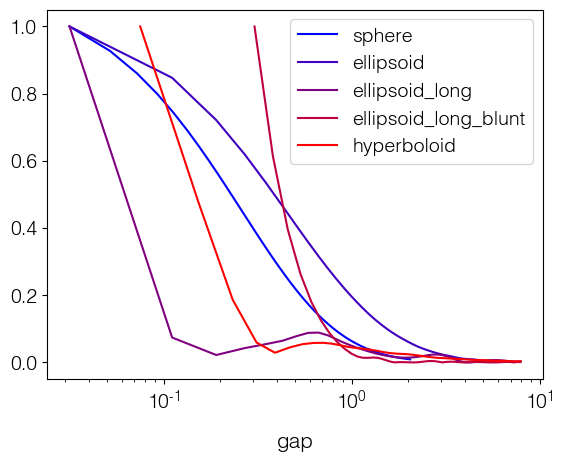

In [713]:
def spline_fit(Y,knot_numbers=50):
    
    x=Y.axes[0]; y=Y
    x_new = np.linspace(0, 1, knot_numbers+2)[1:-1]
    q_knots = np.quantile(x, x_new)
    t,c,k = interpolate.splrep(x, y.real, t=q_knots, s=1)
    yfitr = interpolate.BSpline(t,c,k)(x)
    t,c,k = interpolate.splrep(x, y.imag, t=q_knots, s=1)
    yfiti = interpolate.BSpline(t,c,k)(x)
    yfit = yfitr+yfiti * 1j
    
    return AWA(yfit,adopt_axes_from=Y)

def get_AC(E,Ndemod=144,amp=2,N=100):
    
    gaps = np.linspace(E.axes[0].min(),
                       E.axes[0].max()-2.1*amp,N)
    gaps_sub,_ = numrec.GetQuadrature(xmin=0,xmax=2*amp,N=Ndemod,quadrature='GL')
    global Esubs
    Esubs=[E.interpolate_axis(gap0+gaps_sub,axis=0,extrapolate=True,
                                kind='quadratic',bounds_error=False) for gap0 in gaps]
    Esubs = AWA(np.array(Esubs).T,axes=[gaps_sub,gaps])
    demod = PCE.demodulate(Esubs)
    print(demod.axis_limits,demod.axis_names)
    
    return AWA(demod[3],axes=[gaps],axis_names=['gap'])

cs=plotting.bluered_colors(len(probes))

Nmodes=20
Ndemod=244
amp=1
smoothing=20
Es={}
for probe in probes:
    GS = PCE.PC[probe].gapSpectroscopy()
    c=next(cs)
    Bs=GS.get_eigenbrightness_AWA()[:Nmodes]
    Ps=GS.get_eigenrhos_AWA()[:Nmodes]
    
    """Bs = AWA([spline_fit(B) for B in Bs],
             adopt_axes_from=Bs)
    Ps = AWA([spline_fit(P) for P in Ps],
             adopt_axes_from=Ps)"""
    
    E = np.sum(Bs**2*(1/(beta-Ps)+1/Ps),
               axis=0)
    #E-=E.cslice[10]
    E/=np.abs(E).max()
    Es[probe]=E
    
    
    E0 = np.sum(Bs**2/Ps**2*beta,
                axis=0)
    #E0-=E0.cslice[10]
    E0/=np.abs(E0).max()
    E0 = spline_fit(E0,knot_numbers=20)
    
    f1=plt.figure(1)
    np.abs(E).plot(color=c,label=probe)
    np.abs(E0).plot(color=c,ls='--')
    
    #--- Demodulated
    f2=plt.figure(2)
    AC = get_AC(E0,amp=amp,Ndemod=Ndemod)
    AC/=np.abs(AC).max()
    np.abs(AC).plot(color=c,label=probe)
        

plt.figure(1)
plt.legend()
plt.gca().set_xscale('log')

plt.figure(2)
plt.legend()
plt.gca().set_xscale('log')

['Angle (deg.)', 'axis1']


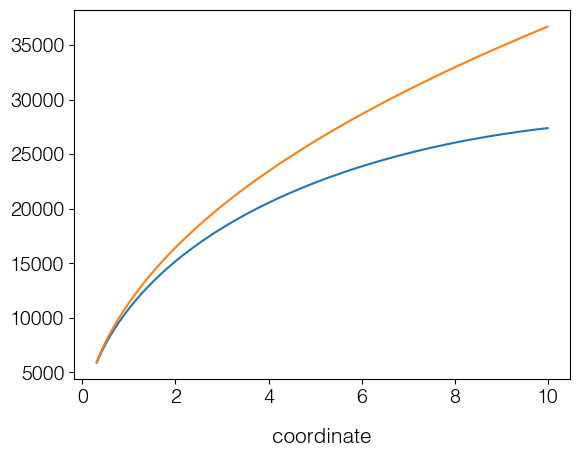

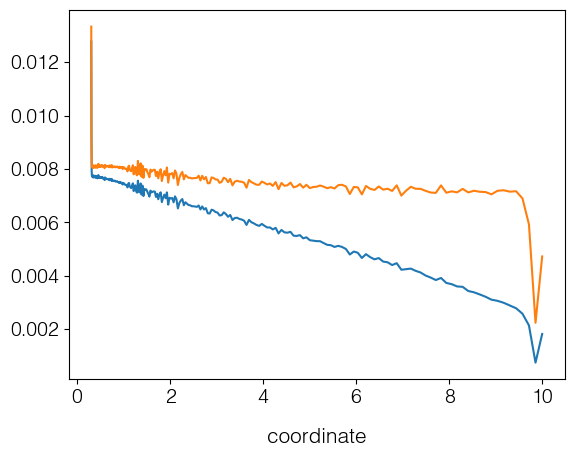

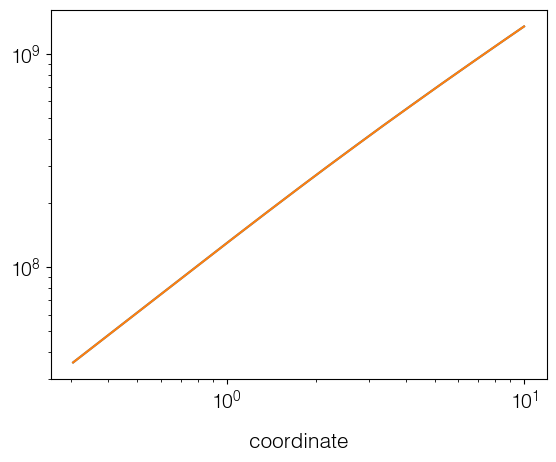

In [683]:
probe='hyperboloid'
#probe='ellipsoid_long'
probe='ellipsoid_long_blunt'
P=PCE.PC[probe]
ei=2

Ps = P.gapSpectroscopy().get_eigenrhos_AWA()
Qs = P.gapSpectroscopy().get_eigencharges_AWA()
Bs = P.gapSpectroscopy().get_eigenbrightness_AWA(recompute=False,
                                                 angles=None)

ei=9
X=Bs[ei]**2#/Ps[ei]**2
#X=1/Ps[ei**2]


Qs = PCE.PC[probe].gapSpectroscopy().get_eigencharges_AWA(recompute=False)[ei]

plt.figure()
Bs = P.get_brightness(Qs,Nphis=1)
print(Bs.axis_names)
B=np.mean(Bs,axis=0)
B.set_axes([Qs.axes[0]])
np.abs(B).plot()

B2 = PCE.PC[probe].gapSpectroscopy().get_eigenbrightness_AWA(recompute=False,
                                                            angles=None,Nphis=48)[ei]
np.abs(B2).plot()

plt.figure()
X=B**2
Xsmooth = numrec.smooth(X,axis=0,window_len=10)
np.abs((X-Xsmooth)/X).plot()
X=B2**2
Xsmooth = numrec.smooth(X,axis=0,window_len=10)
np.abs((X-Xsmooth)/X).plot()

from scipy import interpolate

def spline_fit(X,knot_numbers=5):
    
    x=X.axes[0]; y=X
    x_new = np.linspace(0, 1, knot_numbers+2)[1:-1]
    q_knots = np.quantile(x, x_new)
    t,c,k = interpolate.splrep(x, y.real, t=q_knots, s=1)
    yfitr = interpolate.BSpline(t,c,k)(x)
    t,c,k = interpolate.splrep(x, y.imag, t=q_knots, s=1)
    yfiti = interpolate.BSpline(t,c,k)(x)
    yfit = yfitr+yfiti * 1j
    
    return yfit

In [948]:
def test(x,args):
    
    a,b,p=args
    return a/(b+x**p)

xs=Erad4.axes[0]; ys=Erad4
result=numrec.ParameterFit(xs,ys,test,(1,1,-1))[0]
print(result)

[22.09777249  9.2812338   0.82676114]


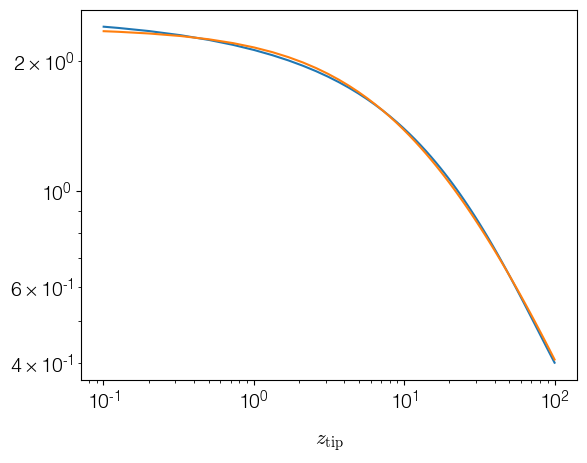

In [949]:
Erad4.plot()
plt.plot(xs,test(xs,result))
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

In [ ]:
ei=0

def test(x,args):
    
    a,b,c,d,p=args
    A=a+1j*b
    B=c+1j*d
    return A/(B+x)**p

ys=Ps1[ei]; xs=ys.axes[0]
np.abs(ys).plot()
result=numrec.ParameterFit(xs,ys,test,(ys.real.min(),1,1,1,-2),error_exp=2)[0]
result=numrec.ParameterFit(xs,ys,test,result,error_exp=.5)[0]
print(result)
plt.plot(xs,np.abs(test(xs,result)))

plt.twinx()

def test(x,args):
    
    a,b,c,d,p=args
    A=a+1j*b
    B=c+1j*d
    return A/(B+x)**p

ys=Bs1[ei]; xs=ys.axes[0]
np.abs(ys).plot()
result=numrec.ParameterFit(xs,ys,test,(1,1,1,1,-1),error_exp=2)[0]
result=numrec.ParameterFit(xs,ys,test,result,error_exp=.5)[0]
result=numrec.ParameterFit(xs,ys,test,result,error_exp=.1)[0]
print(result)
plt.plot(xs,np.abs(test(xs,result)))


# Calculating spectra as a diagnostic

## Prepare and verify encoding

In [41]:
P=P4
#Encoding0=getProbeEncoding4(GS4_0,reload=True,overwrite=False,recompute=False,Nmodes=15)
Encoding=getProbeEncoding4(GS4,reload=True,overwrite=False,recompute=True,Nmodes=15) #This is the one we want to actually save

<ProbeCavityEigenfields.ProbeSpectroscopy.EncodedEigenfields.__init__>:
	Encoding eigenfields to gap=1 across 359 gap values from gap=0.038 to 32...
<ProbeCavityEigenfields.ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 1.00E+00...
	Updating eigencharges...
	Updating self impedance...
	Updating mirror impedance...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing field propagators at k=0...
	Including evanescent (near-field) waves..
<ProbeCavityEigenfields._ProbesCollection.__setitem__>:
	Overwriting registered probe "hyperboloid"...


0.0016
<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 1.00E+00...
	Updating eigencharges...
	Updating self impedance...
	Updating mirror impedance...
0.0016
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness at k=0.01...


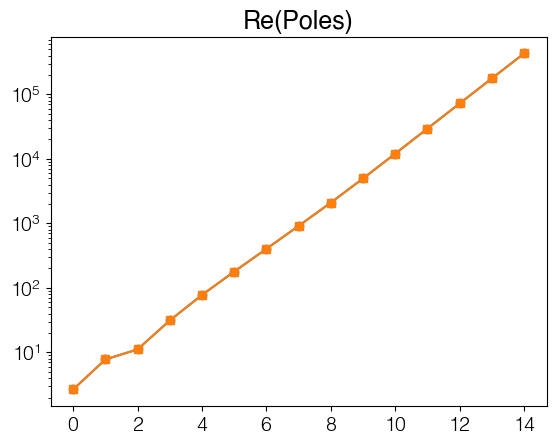

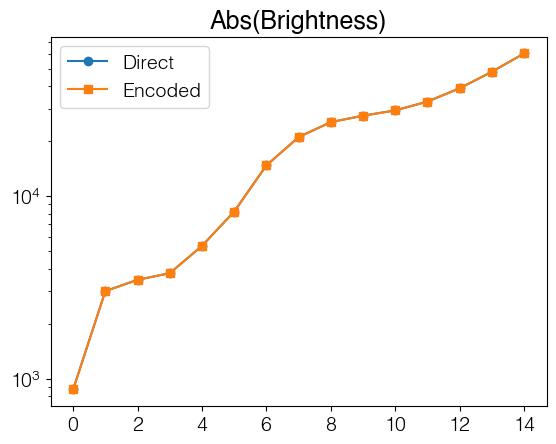

In [12]:
z0=P.get_gap()
GapSpectroscopy=GS4
print(P.get_freq())
print(GapSpectroscopy.get_probe_at_coord(z0).get_freq())

#The eigenindex of poles may have been resorted by spectroscopy
poles_direct = np.sort(P.get_eigenrhos()[:15].real) 
poles_encoded = np.sort(Encoding.Poles.cslice[z0,:15].real)

plt.figure() 
plt.semilogy(poles_direct,marker='o',label='Direct')
plt.semilogy(poles_encoded,marker='s',label='Encoded')
plt.title('Re(Poles)')

Bs_direct = np.sort(np.abs(np.mean(P.get_eigenbrightness()[:,:15],axis=0)))
Bs_encoded = np.sort(np.abs(Encoding.Brightnesses.cslice[z0,:15]))

plt.figure()
plt.semilogy(Bs_direct,marker='o',label='Direct')
plt.semilogy(Bs_encoded,marker='s',label='Encoded')
plt.title('Abs(Brightness)')
plt.legend()

## Uniform settings

In [70]:
from NearFieldOptics import Materials as M


gapmin=0.2
amplitude_nm=80
a_nm=20
gapmin_nm=gapmin*a_nm
amplitude = amplitude_nm / a_nm

freqs_wn_sic = np.linspace(700,1100,50)
freqs_sic = freqs_wn_sic * (a_nm*1e-7)

freqs_wn_sio2=np.linspace(800,1200,50)
freqs_sio2 = freqs_wn_sio2 * (a_nm*1e-7)

## SiO2 spectroscopy

<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators at k=0...
	Including evanescent (near-field) waves..
<__init__.Probe.reset_eigenproperties>:
	Resetting eigenproperties...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness at k=0.01...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0015999999999999999...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators at k=0...
	Including evanescent (near-field) waves..
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0016163265306122449...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators at k=0...
	Including evanescent (near-field) waves..
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0016326530612244899...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators at k=0...
	Including evanescent (near-field) waves..
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.001

<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.002204081632653061...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators at k=0...
	Including evanescent (near-field) waves..
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.002220408163265306...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators at k=0...
	Including evanescent (near-field) waves..
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0022367346938775507...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators at k=0...
	Including evanescent (near-field) waves..
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0022530612244897955...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators at k=0...
	Including evanescent (near-field) waves..
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0022693877551020407...
<__init__.Probe.getFourPotentialPropagat

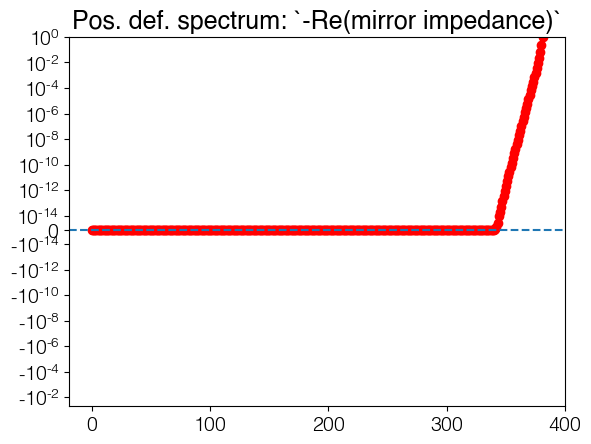

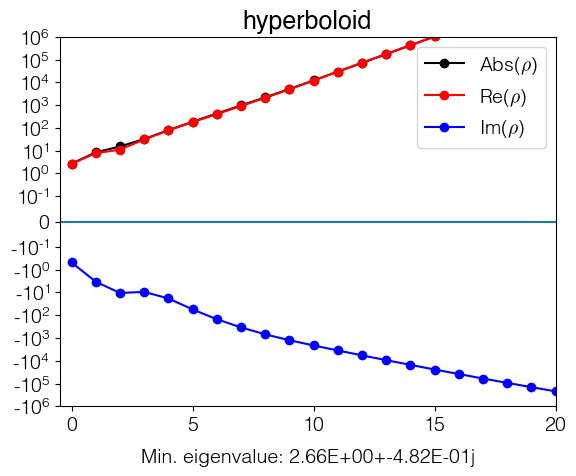

In [53]:
P4.set_gap(1)
P4.get_mirror_impedance(sommerfeld=True,recompute=True,Nkappas=244*4,kappa_max=np.inf)
P4.solve_eigenmodes()
P4.plot_eigenrhos()
Nmodes=100
sio2_0 = P4.getNormalizedSignal(freqs_wn_sio2,rp=M.SiO2_300nm.reflection_p,
                                a_nm=a_nm,amplitude_nm=amplitude_nm,demod_order=5,
                                Ngaps=24,Nkappas=244,gapmin=gapmin,
                                rp_norm = M.Si.reflection_p,
                                freqs_wn_norm = None, Nmodes=Nmodes)

In [54]:
Ngaps=24
sio2_1 = Encoding0.getNormalizedSignal(freqs_wn_sio2,rp=M.SiO2_300nm.reflection_p,
                                        a_nm=a_nm,amplitude_nm=amplitude_nm,demod_order=5,
                                        Ngaps=Ngaps,gapmin_nm=gapmin_nm,
                                        rp_norm = M.Si.reflection_p)
sio2_2 = Encoding.getNormalizedSignal(freqs_wn_sio2,rp=M.SiO2_300nm.reflection_p,
                                        a_nm=a_nm,amplitude_nm=amplitude_nm,demod_order=5,
                                        Ngaps=Ngaps,gapmin_nm=gapmin_nm,
                                        rp_norm = M.Si.reflection_p)
"""si = Encoding.getNormalizedSignal(freqs_wn,rp=M.Si.reflection_p,
                                        a_nm=a_nm,amplitude_nm=80,demod_order=5,
                                        Ngaps=24*4,gapmin_nm=gapmin_nm,
                                        rp_norm = None)
au = Encoding.getNormalizedSignal(freqs_wn,rp=M.Au.reflection_p,
                                        a_nm=a_nm,amplitude_nm=80,demod_order=5,
                                        Ngaps=24*4,gapmin_nm=gapmin_nm,
                                        rp_norm = None)""";

	Computing at freq=1.600E-03...
	Computing at freq=1.616E-03...
	Computing at freq=1.633E-03...
	Computing at freq=1.649E-03...
	Computing at freq=1.665E-03...
	Computing at freq=1.682E-03...
	Computing at freq=1.698E-03...
	Computing at freq=1.714E-03...
	Computing at freq=1.731E-03...
	Computing at freq=1.747E-03...
	Computing at freq=1.763E-03...
	Computing at freq=1.780E-03...
	Computing at freq=1.796E-03...
	Computing at freq=1.812E-03...
	Computing at freq=1.829E-03...
	Computing at freq=1.845E-03...
	Computing at freq=1.861E-03...
	Computing at freq=1.878E-03...
	Computing at freq=1.894E-03...
	Computing at freq=1.910E-03...
	Computing at freq=1.927E-03...
	Computing at freq=1.943E-03...
	Computing at freq=1.959E-03...
	Computing at freq=1.976E-03...
	Computing at freq=1.992E-03...
	Computing at freq=2.008E-03...
	Computing at freq=2.024E-03...
	Computing at freq=2.041E-03...
	Computing at freq=2.057E-03...
	Computing at freq=2.073E-03...
	Computing at freq=2.090E-03...
	Computi

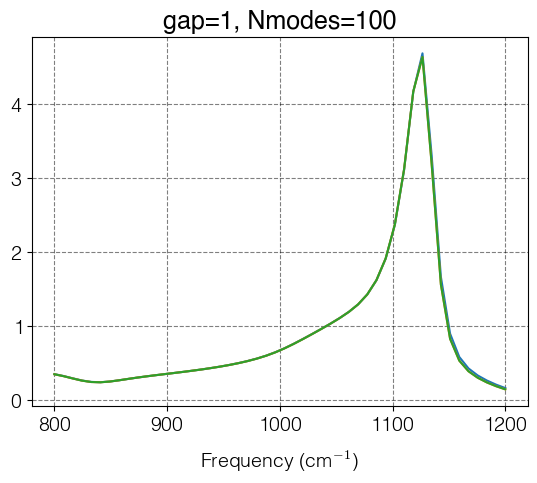

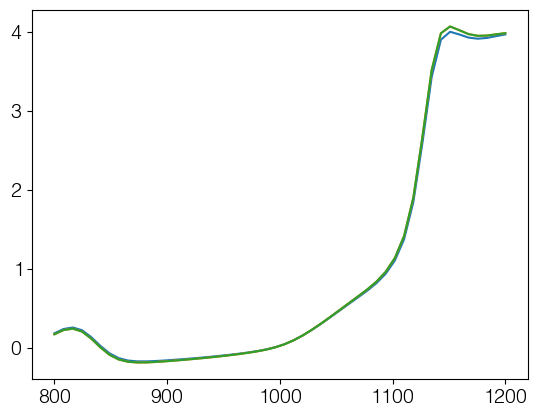

In [55]:
"""angle=50; dangle=15
angles = np.linspace(angle-dangle/2,angle+dangle/2,20)
R = np.mean([M.SiC_6H.reflection_p(freqs_wn,angle=angle) for angle in angles],axis=0)
R0 = np.mean([M.Si.reflection_p(freqs_wn,angle=angle) for angle in angles],axis=0)
f=0.5*np.exp(1j*np.pi/2*1)
FFF=(1+f*R)**2/(1+f*R0)**2"""
FFF=1

signal0 = sio2_0['Sn'][3]
signal1 = sio2_1['Sn'][3]
signal2 = sio2_2['Sn'][3]

np.abs(signal0*FFF).plot()
np.abs(signal1*FFF).plot()
np.abs(signal2*FFF).plot()
#plt.ylim(0,5)
#plt.xticks((600,800,900,1000,1100))
#plt.xlim(700,1100)
plt.grid(ls='--',alpha=.5,color='k')
plt.title('gap=%s, Nmodes=%s'%(P4.get_gap(),Nmodes))

plt.figure()
plt.plot(freqs_wn,np.unwrap(np.angle(signal0*FFF)))
plt.plot(freqs_wn,np.unwrap(np.angle(signal1*FFF)))
plt.plot(freqs_wn,np.unwrap(np.angle(signal2*FFF)))

## SiC spectroscopy

In [73]:
sic0 = P4.getNormalizedSignal(freqs_wn_sic,rp=M.SiC_6H.reflection_p,
                                a_nm=a_nm,amplitude_nm=amplitude_nm,demod_order=5,
                                Ngaps=24,Nkappas=244,gapmin=gapmin,
                                rp_norm = M.Si.reflection_p,
                                freqs_wn_norm = None)

<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0014...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators at k=0...
	Including evanescent (near-field) waves..
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0014163265306122448...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators at k=0...
	Including evanescent (near-field) waves..
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0014326530612244898...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators at k=0...
	Including evanescent (near-field) waves..
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0014489795918367345...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators at k=0...
	Including evanescent (near-field) waves..
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0014653061224489795...
<__init__.Probe.getFourPotentialPropagators>:
	Comput

<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.002020408163265306...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators at k=0...
	Including evanescent (near-field) waves..
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.002036734693877551...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators at k=0...
	Including evanescent (near-field) waves..
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.002053061224489796...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators at k=0...
	Including evanescent (near-field) waves..
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.002069387755102041...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators at k=0...
	Including evanescent (near-field) waves..
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.002085714285714286...
<__init__.Probe.getFourPotentialPropagators

In [197]:
from NearFieldOptics import Materials as M
Ngaps=24*8
sic1 = Encoding.getNormalizedSignal(freqs_wn_sic,rp=M.SiC_6H.reflection_p,
                                        a_nm=a_nm,amplitude_nm=amplitude_nm,demod_order=5,
                                        Ngaps=Ngaps,gapmin_nm=gapmin_nm,
                                        rp_norm = M.Si.reflection_p)
sic2 = Encoding.getNormalizedSignal(freqs_wn_sic,rp=M.SiC_6H.reflection_p,
                                        a_nm=a_nm*.6,amplitude_nm=amplitude_nm,demod_order=5,
                                        Ngaps=Ngaps,gapmin_nm=a_nm/10,
                                        rp_norm = M.Si.reflection_p) # 12nm probe radius, close to sample as reasonable
"""si = Encoding.getNormalizedSignal(freqs_wn,rp=M.Si.reflection_p,
                                        a_nm=a_nm,amplitude_nm=80,demod_order=5,
                                        Ngaps=24*4,gapmin_nm=gapmin_nm,
                                        rp_norm = None)
au = Encoding.getNormalizedSignal(freqs_wn,rp=M.Au.reflection_p,
                                        a_nm=a_nm,amplitude_nm=80,demod_order=5,
                                        Ngaps=24*4,gapmin_nm=gapmin_nm,
                                        rp_norm = None)"""

	Computing at freq=1.400E-03...
	Computing at freq=1.416E-03...
	Computing at freq=1.433E-03...
	Computing at freq=1.449E-03...
	Computing at freq=1.465E-03...
	Computing at freq=1.482E-03...
	Computing at freq=1.498E-03...
	Computing at freq=1.514E-03...
	Computing at freq=1.531E-03...
	Computing at freq=1.547E-03...
	Computing at freq=1.563E-03...
	Computing at freq=1.580E-03...
	Computing at freq=1.596E-03...
	Computing at freq=1.612E-03...
	Computing at freq=1.629E-03...
	Computing at freq=1.645E-03...
	Computing at freq=1.661E-03...
	Computing at freq=1.678E-03...
	Computing at freq=1.694E-03...
	Computing at freq=1.710E-03...
	Computing at freq=1.727E-03...
	Computing at freq=1.743E-03...
	Computing at freq=1.759E-03...
	Computing at freq=1.776E-03...
	Computing at freq=1.792E-03...
	Computing at freq=1.808E-03...
	Computing at freq=1.824E-03...
	Computing at freq=1.841E-03...
	Computing at freq=1.857E-03...
	Computing at freq=1.873E-03...
	Computing at freq=1.890E-03...
	Computi

'si = Encoding.getNormalizedSignal(freqs_wn,rp=M.Si.reflection_p,\n                                        a_nm=a_nm,amplitude_nm=80,demod_order=5,\n                                        Ngaps=24*4,gapmin_nm=gapmin_nm,\n                                        rp_norm = None)\nau = Encoding.getNormalizedSignal(freqs_wn,rp=M.Au.reflection_p,\n                                        a_nm=a_nm,amplitude_nm=80,demod_order=5,\n                                        Ngaps=24*4,gapmin_nm=gapmin_nm,\n                                        rp_norm = None)'

(700.0, 1100.0)

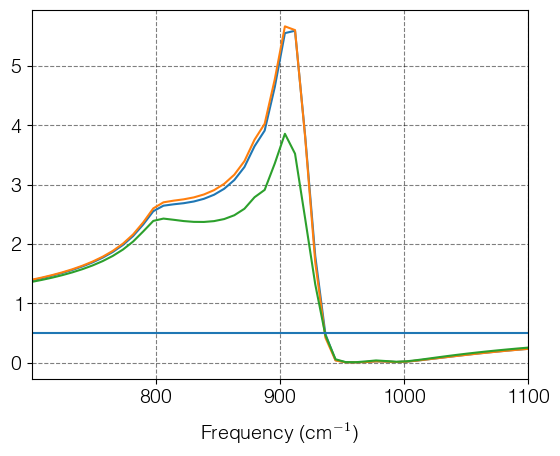

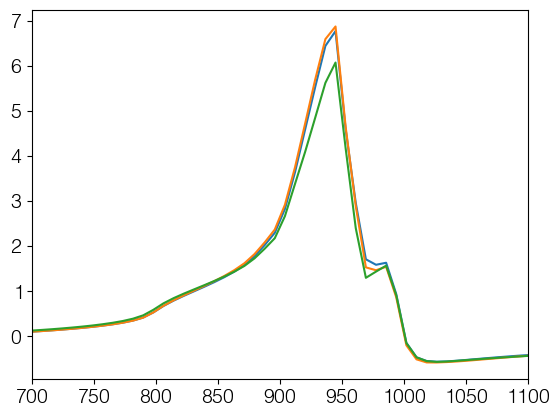

In [198]:
angle=50; dangle=15
angles = np.linspace(angle-dangle/2,angle+dangle/2,20)
R = np.mean([M.SiC_6H.reflection_p(freqs_wn_sic,angle=angle) for angle in angles],axis=0)
R0 = np.mean([M.Si.reflection_p(freqs_wn_sic,angle=angle) for angle in angles],axis=0)
f=0.8*np.exp(1j*np.pi/2*.7) #This is a little fine-tuned for the existing data
FFF=(1+f*R)**2/(1+f*R0)**2
#FFF=1

signal0 = sic0['Sn'][3]
signal1 = sic1['Sn'][3]
signal2 = sic2['Sn'][3]

np.abs(signal0*FFF).plot()
np.abs(signal1*FFF).plot()
np.abs(signal2*FFF).plot()
#plt.ylim(0,5)
plt.axhline(.5)
plt.xticks((600,800,900,1000,1100))
plt.xlim(700,1100)
plt.grid(ls='--',alpha=.5,color='k')

plt.figure()
plt.plot(freqs_wn_sic,np.unwrap(np.angle(signal0*FFF)))
plt.plot(freqs_wn_sic,np.unwrap(np.angle(signal1*FFF)))
plt.plot(freqs_wn_sic,np.unwrap(np.angle(signal2*FFF)))
plt.xlim(700,1100)

![alt text](SiC_ExperimentalS3_80nmTapping_NormSi_WithFarField.png "Title")

(0.0, 1.1)

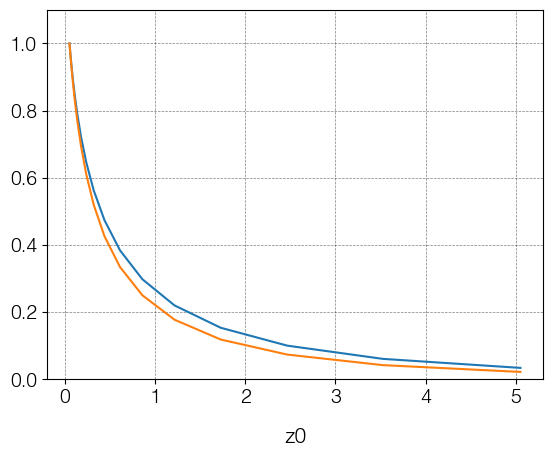

In [611]:
np.abs(c1).plot()
np.abs(c2).plot()
#plt.xticks([0,20,40,60,80,100])
#plt.xlim(0,100)
plt.grid(alpha=.5,color='k')
plt.ylim(0,1.1)
#plt.axhline(.5,color='r')
#plt.axvline(16,color='r')

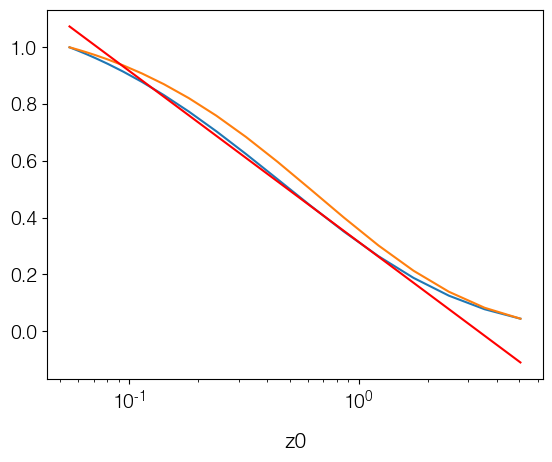

In [534]:
np.abs(c1).plot(plotter=plt.semilogx)
np.abs(c2).plot(plotter=plt.semilogx)
plt.semilogx(zs_norm,np.pi/12*(1.2-np.log(zs_norm)),color='r')